## Explain the footprint heterogeneity

In [217]:
from basepair.imports import *

from basepair.exp.paper.config import *

fdir = Path(f'{ddir}/figures/method-comparison/vplot')
fdir.mkdir(exist_ok=True)

fdir_atac = Path(f'{ddir}/figures/method-comparison/atac')
fdir_atac.mkdir(exist_ok=True)

In [65]:
from basepair.cli.schemas import DataSpec, TaskSpec 
from pybedtools import BedTool
from basepair.preproc import resize_interval

from basepair.plot.evaluate import regression_eval

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
paper_config()

In [5]:
ATAC_PROC_DIR = Path('/oak/stanford/groups/akundaje/projects/bpnet/ATACseq_processed')
CROO_DIR = ATAC_PROC_DIR / 'croo'
OUTPUT_DIR = Path('/oak/stanford/groups/akundaje/avsec/basepair/data/processed/comparison/data/atac')
METHODS = ['BPNet', 'MEME/FIMO']
dfi_list_dir = '/oak/stanford/groups/akundaje/avsec/basepair/data/processed/comparison/chexmix-peakxus'
closest_motifs = read_pkl("/oak/stanford/groups/akundaje/avsec/basepair/data/processed/comparison/chexmix-peakxus/closest_motifs.pkl")
motifs = list(closest_motifs)

In [6]:
df_id = pd.read_csv(ATAC_PROC_DIR / 'id_to_sample.txt', sep='\t',
                    usecols=['id', 'status', 'name', 'str_label'])

sample_to_id = {row.str_label: row.id for i,row in df_id.iterrows()}


samples = list(sample_to_id)

In [7]:
fasta_file = '/oak/stanford/groups/akundaje/avsec/basepair/data/processed/comparison/data/mm10_no_alt_analysis_set_ENCODE.fasta'

In [8]:
main_motifs = ['Oct4-Sox2', 'Sox2', 'Nanog', 'Klf4']

In [9]:
### Load the data

In [10]:
# dfi_list
dfi_list = read_pkl(f'{dfi_list_dir}/dfi_list.incl-conservation,is_erv.pkl')

dfi = dfi_list['BPNet']['dfi']

In [11]:
dict(dfi.example_chrom.value_counts())

{'chr2': 18216,
 'chr11': 16638,
 'chr1': 16558,
 'chr5': 16079,
 'chr4': 15817,
 'chr8': 14459,
 'chr7': 14229,
 'chr6': 13567,
 'chr9': 13068,
 'chr10': 13002,
 'chr3': 12079,
 'chr13': 11884,
 'chr17': 10609,
 'chr12': 9348,
 'chr14': 9332,
 'chr15': 9084,
 'chr16': 8419,
 'chr18': 7527,
 'chr19': 6525}

In [12]:
# ChIP-nexus profiles, ranges
exp = 'nexus,peaks,OSNK,0,10,1,FALSE,same,0.5,64,25,0.004,9,FALSE,[1,50],TRUE'
model_dir = models_dir / exp

isf = ImpScoreFile(model_dir / 'deeplift.imp_score.h5', default_imp_score='profile/wn')

profiles = isf.get_profiles()
ranges = isf.get_ranges()
seqs = isf.get_seq()
contrib = isf.get_contrib()

In [14]:
np.argmax(seqs[:5, :5], axis=-1)

array([[3, 1, 1, 0, 3],
       [0, 2, 0, 0, 0],
       [0, 0, 3, 3, 3],
       [2, 1, 1, 1, 0],
       [2, 3, 2, 3, 2]])

In [15]:
contrib_size = {task: v.sum(axis=-1) for task, v in contrib.items()}

In [16]:
from basepair.preproc import moving_average

In [17]:
_x = np.ravel(moving_average(contrib_size['Oct4'].swapaxes(0, 1), n=10).swapaxes(0,1))

In [18]:
np.mean(_x > 0.1)

5.079270682687499e-05

In [20]:
from kipoi.data import Dataset


class MotifMask(Dataset):

    def __init__(self, dfi, seqs, index_col='example_idx'):
        self.dfi = dfi.copy().set_index(index_col, drop=False)
        self.seqs = seqs
        self.index_col = index_col

    def __len__(self):
        return len(self.seqs)

    def __getitem__(self, idx):
        out = np.zeros((self.seqs.shape[1])).astype(bool)
        
        # Get instances
        if idx not in self.dfi.index:
            # no rows. Return the same sequence.
            return out
        instances = self.dfi.loc[[idx]]
        assert np.all(instances[self.index_col] == idx)
        
        # asign motif locations
        for i,inst in instances.iterrows():
            seqlen = inst.pattern_end - inst.pattern_start
            out[int(inst.pattern_start):int(inst.pattern_end)] = True

        return out

In [21]:
all_motif_mask = MotifMask(dfi, seqs).load_all(num_workers=10)

100%|██████████| 4625/4625 [02:43<00:00, 28.30it/s]


In [23]:
dsox2_motifs = ['Oct4-Sox2', 'Sox2']
doct4_motifs = ['Oct4-Sox2', 'Oct4', 'Oct4-Oct4']

In [24]:
sox2_mask = MotifMask(dfi[dfi.pattern_name.isin(dsox2_motifs)], seqs).load_all(num_workers=10)
oct4_mask = MotifMask(dfi[dfi.pattern_name.isin(doct4_motifs)], seqs).load_all(num_workers=10)
all_motif_mask = MotifMask(dfi, seqs).load_all(num_workers=10)

100%|██████████| 4625/4625 [02:43<00:00, 28.23it/s]


In [25]:
print("Sox2 motifs cover", sox2_mask.mean())
print("Oct4 motifs cover", oct4_mask.mean())
print("All motifs cover", all_motif_mask.mean())

Sox2 motifs cover 0.005216450187195048
Oct4 motifs cover 0.004969352724127211
All motifs cover 0.01878758430535094


### How many of these sites are of high importance?

In [233]:
from basepair.modisco.sliding_similarities import pad_same

In [26]:
# ~40% of all sites with high importance is covered by motifs

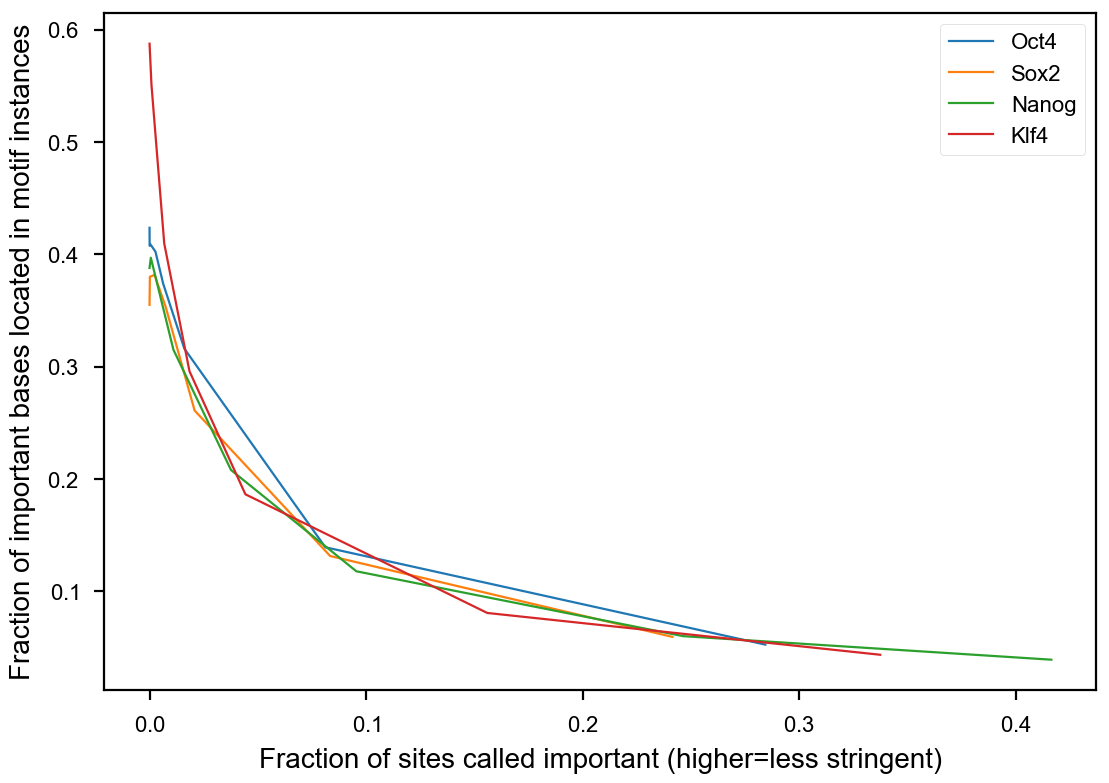

In [27]:
t_list = [0.5, 0.3, 0.2, 0.1, 0.05, 0.02, 0.01, 0.005, 0.002, 0.001]
for task in tasks:
    _x = moving_average(contrib_size[task].swapaxes(0, 1), n=10).swapaxes(0,1)
    plt.plot([np.mean(_x>t) for t in t_list],
             [np.sum((_x>t) & all_motif_mask) / np.sum(_x>t) for t in t_list], label=task)
plt.xlabel("Fraction of sites called important (higher=less stringent)")
plt.ylabel("Fraction of important bases located in motif instances")
plt.legend()

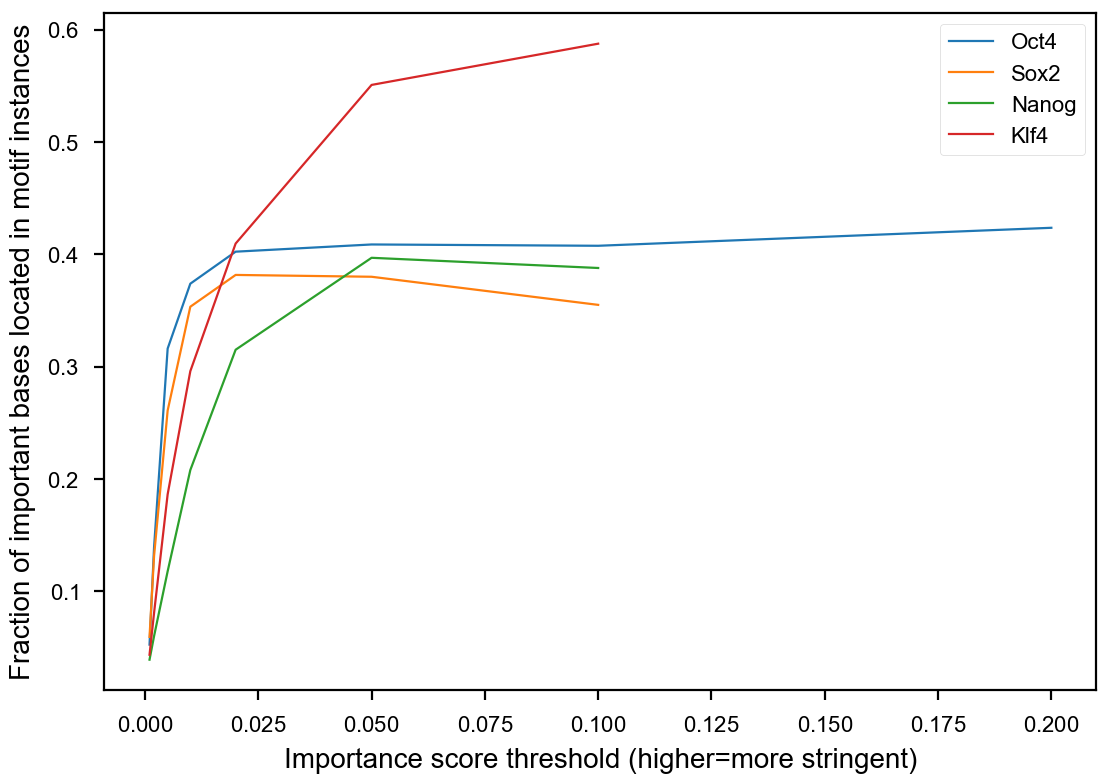

In [28]:
t_list = [0.5, 0.3, 0.2, 0.1, 0.05, 0.02, 0.01, 0.005, 0.002, 0.001]
for task in tasks:
    _x = moving_average(contrib_size[task].swapaxes(0, 1), n=10).swapaxes(0,1)
    plt.plot(t_list, [np.sum((_x>t) & all_motif_mask) / np.sum(_x>t) for t in t_list], label=task)
plt.xlabel("Importance score threshold (higher=more stringent)")
plt.ylabel("Fraction of important bases located in motif instances")
plt.legend()

Text(0.5, 1.0, 'Sox2 motif mask')

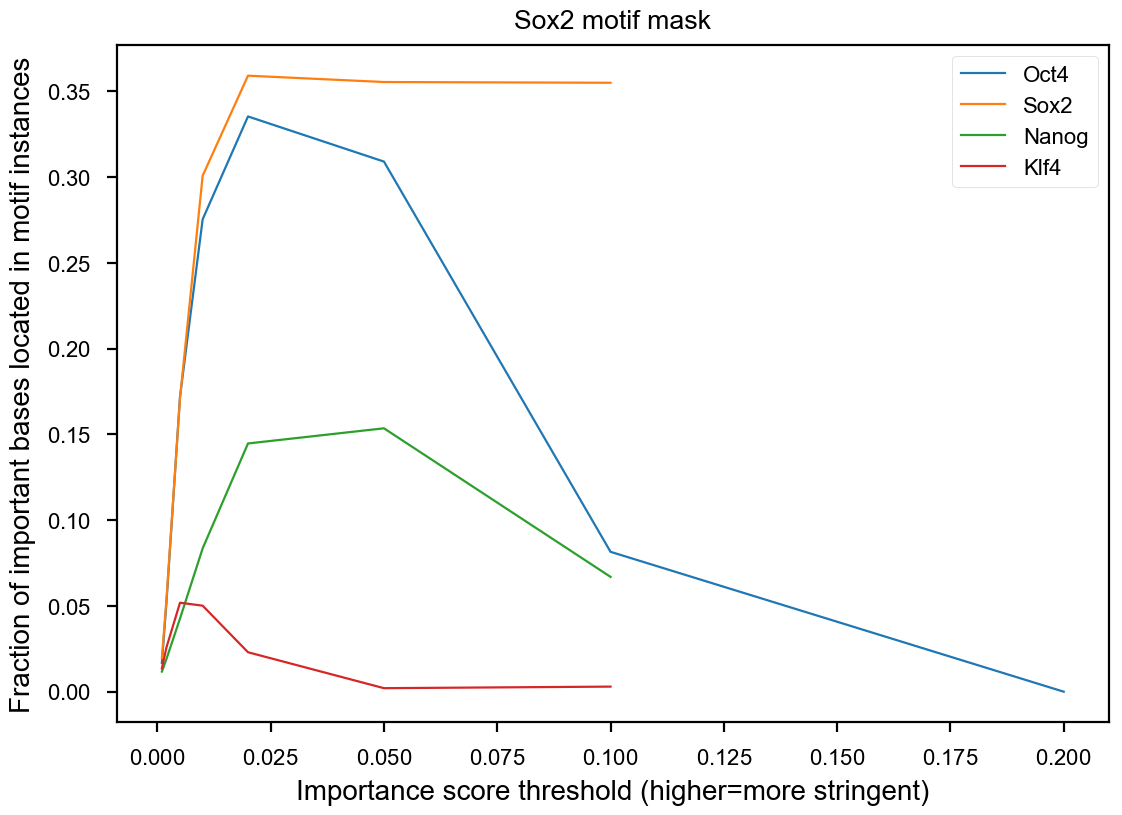

In [29]:
t_list = [0.5, 0.3, 0.2, 0.1, 0.05, 0.02, 0.01, 0.005, 0.002, 0.001]
for task in tasks:
    _x = moving_average(contrib_size[task].swapaxes(0, 1), n=10).swapaxes(0,1)
    plt.plot(t_list, [np.sum((_x>t) & sox2_mask) / np.sum(_x>t) for t in t_list], label=task)
plt.legend()
plt.xlabel("Importance score threshold (higher=more stringent)")
plt.ylabel("Fraction of important bases located in motif instances")
plt.title("Sox2 motif mask")

Text(0.5, 1.0, 'Oct4 motif mask')

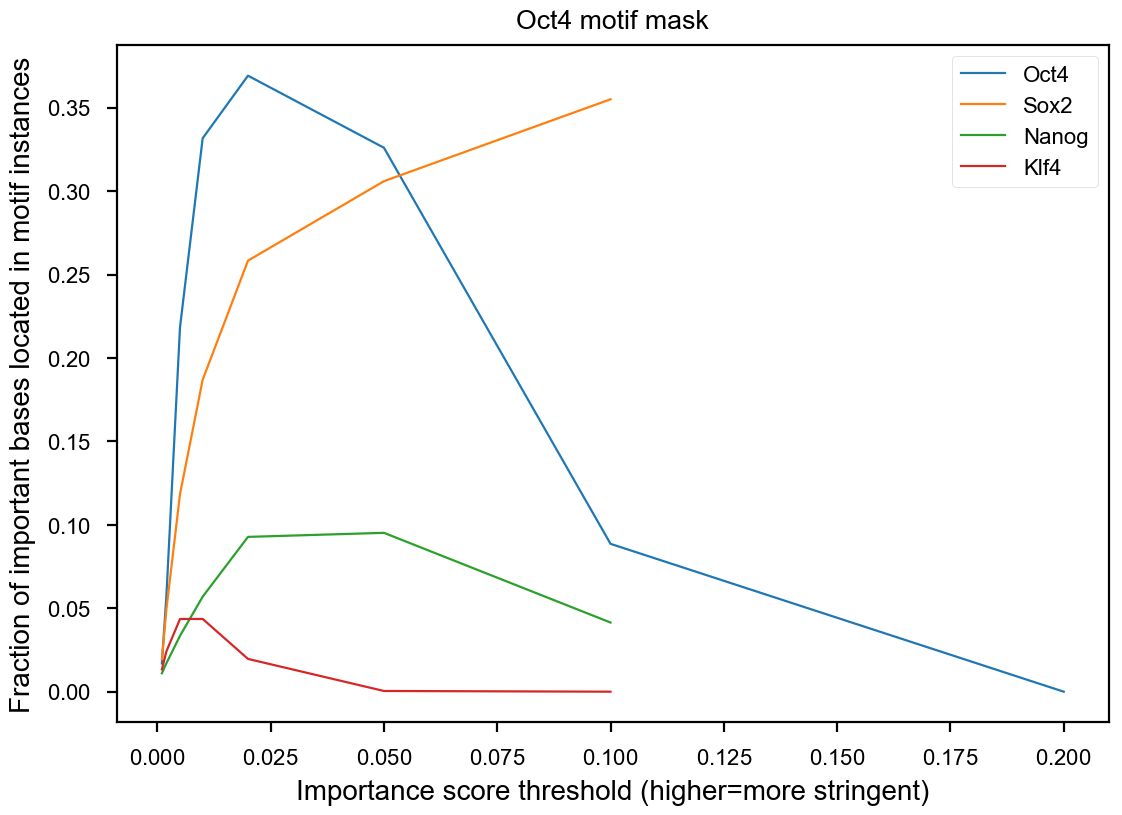

In [30]:
t_list = [0.5, 0.3, 0.2, 0.1, 0.05, 0.02, 0.01, 0.005, 0.002, 0.001]
for task in tasks:
    _x = moving_average(contrib_size[task].swapaxes(0, 1), n=10).swapaxes(0,1)
    plt.plot(t_list, [np.sum((_x>t) & oct4_mask) / np.sum(_x>t) for t in t_list], label=task)
plt.legend()
plt.xlabel("Importance score threshold (higher=more stringent)")
plt.ylabel("Fraction of important bases located in motif instances")
plt.title("Oct4 motif mask")

In [31]:
ranges['example_idx'] = ranges['idx']

### Get the ATAC profiles

In [32]:
# Centered at the ChIP-nexus data
ds = DataSpec(task_specs={sample: TaskSpec(pos_counts=f'{OUTPUT_DIR}/{sample}/coverage.sub150bp-fragments.pos.bw',
                                           neg_counts=f'{OUTPUT_DIR}/{sample}/coverage.sub150bp-fragments.neg.bw',
                                           task=sample)
                          for sample in samples},
              fasta_file=fasta_file)

In [33]:
ds.touch_all_files()

In [34]:
from basepair.extractors import Interval

In [35]:
ranges

,chrom,start,end,strand,interval_from_task,idx,example_idx
0,chr9,3001633,3002633,.,Oct4,0,0
1,chr3,122145077,122146077,.,Oct4,1,1
2,chr13,21199761,21200761,.,Oct4,2,2
...,...,...,...,...,...,...,...
147971,chr9,65390119,65391119,.,Klf4,147971,147971
147972,chr13,12440944,12441944,.,Klf4,147972,147972
147973,chr13,101784985,101785985,.,Klf4,147973,147973


In [36]:
from pybedtools import BedTool

In [37]:
all_intervals = list(BedTool.from_dataframe(ranges[['chrom', 'start', 'end']]))

In [38]:
tasks = ['Oct4', 'Sox2', 'Nanog', 'Klf4']

In [39]:
atac_profile = ds.load_counts(all_intervals)

### Analyze raw data

#### Fraction of ATAC peaks overlapping ChIP-nexus peaks

In [40]:
def atac_peak_path(sample):
    return f'{CROO_DIR}/{sample_to_id[sample]}/peak/idr_reproducibility/idr.optimal_peak.narrowPeak.gz'

In [41]:
atac_peak_paths = {sample: atac_peak_path(sample) for sample in samples}

In [42]:
# Use new code from pyranges
import pyranges as pr

In [43]:
from pyranges import PyRanges
def read_bed(f, output_df=False, nrows=None):

    columns = "Chromosome Start End Name Score Strand ThickStart ThickEnd ItemRGB BlockCount BlockSizes BlockStarts".split(
    )

    if f.endswith(".gz"):
        import gzip
        first_start = gzip.open(f).readline().split()[1]
    else:
        first_start = open(f).readline().split()[1]

    header = None

    try:
        int(first_start)
    except ValueError:
        header = 0

    df = pd.read_csv(
        f,
        dtype={
            "Chromosome": "category",
            "Strand": "category"
        },
        nrows=nrows,
        header=header,
        sep="\t")

    df.columns = columns[:df.shape[1]]

    if not output_df:
        return PyRanges(df)
    else:
        return df

In [44]:
for sample in samples:
    atac_peaks = read_bed(atac_peak_path(sample))
    atac_peaks = atac_peaks[['Chromosome', 'Start', 'End', 'ThickStart', 'BlockCount']]
    # ThickStart -> signalValue
    # BlockCount -> peak
    atac_peaks = atac_peaks.set_columns(['Chromosome', 'Start', 'End', 'signal_value', 'peak_summit'])

    ranges_pr = pr.PyRanges(ranges.rename(columns={'chrom': 'Chromosome', 'start': 'Start', 'end': 'End', 'idx': 'example_idx'}))

    ranges[f'overlaps_{sample}'] = ranges['idx'].isin(np.unique(ranges_pr.intersect(atac_peaks).example_idx))

In [45]:
ranges[[c for c in ranges if c.startswith('overlaps_')]].mean()

overlaps_ATAC_SOX2ON_26h      0.2513
overlaps_ATAC_SOX2OFF_26h     0.1970
overlaps_ATAC_OCT4ON_S2iL     0.3693
overlaps_ATAC_OCT4OFF_S2iL    0.2349
overlaps_ATAC_SOX2ON_40h      0.3373
overlaps_ATAC_SOX2OFF_40h     0.2569
dtype: float64

### ATAC count distribution within ChIP-nexus peak

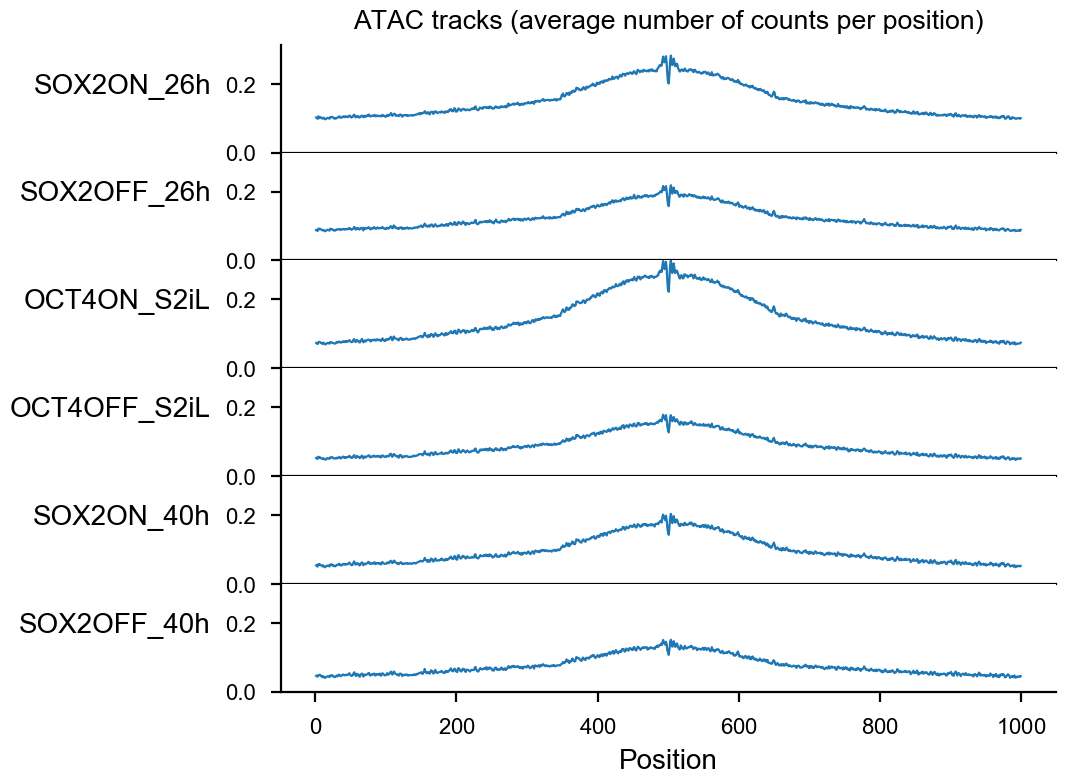

In [28]:
from basepair.plot.tracks import plot_tracks

plot_tracks({sample.replace('ATAC_', ''): counts.mean(axis=0).sum(axis=-1) for sample,counts in atac_profile.items()},
            fig_width=5,
            fig_height_per_track=.7,
            same_ylim=True,
            rotate_y=0,
            title=f'ATAC tracks (average number of counts per position)');
plt.xlabel('Position')
sns.despine(top=True, right=True)

#### ATAC counts at ChIP-nexus peaks that overlap/don't overlap ATAC peaks

In [46]:
# Append total number of counts to ranges
for sample,counts in atac_profile.items():
    ranges[sample] = counts.sum(axis=(1,2))

In [47]:
# tidy table
ranges_melt = ranges.melt(id_vars=[c for c in ranges.columns if c not in samples],
                          value_vars=samples)
ranges_melt['log10_value'] = np.log10(1+ranges_melt['value'])
ranges_melt['variable'] = ranges_melt['variable'].str.replace('ATAC_', '')
ranges_melt

,chrom,start,end,strand,interval_from_task,idx,example_idx,overlaps_ATAC_SOX2ON_26h,overlaps_ATAC_SOX2OFF_26h,overlaps_ATAC_OCT4ON_S2iL,overlaps_ATAC_OCT4OFF_S2iL,overlaps_ATAC_SOX2ON_40h,overlaps_ATAC_SOX2OFF_40h,variable,value,log10_value
0,chr9,3001633,3002633,.,Oct4,0,0,False,True,False,False,False,False,SOX2ON_26h,198.0,2.2989
1,chr3,122145077,122146077,.,Oct4,1,1,False,True,True,False,True,True,SOX2ON_26h,142.0,2.1553
2,chr13,21199761,21200761,.,Oct4,2,2,True,True,True,True,True,True,SOX2ON_26h,212.0,2.3284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887841,chr9,65390119,65391119,.,Klf4,147971,147971,False,False,False,False,False,False,SOX2OFF_40h,56.0,1.7559
887842,chr13,12440944,12441944,.,Klf4,147972,147972,True,False,False,False,True,False,SOX2OFF_40h,23.0,1.3802
887843,chr13,101784985,101785985,.,Klf4,147973,147973,False,True,True,False,True,True,SOX2OFF_40h,99.0,2.0000


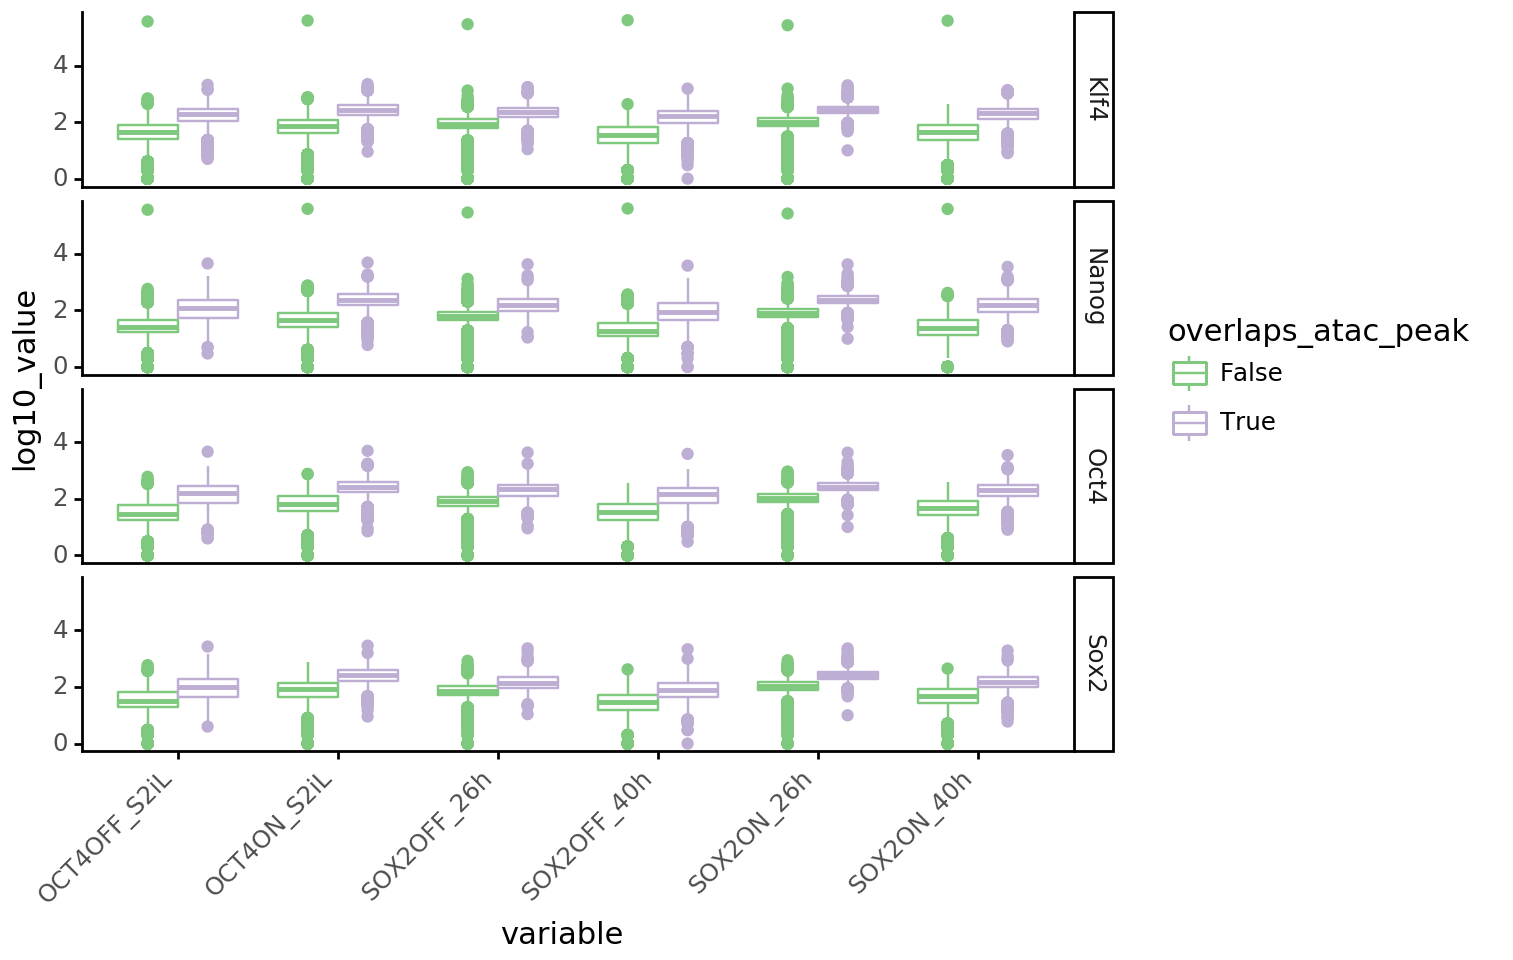

<ggplot: (8759959251632)>

In [175]:
from basepair.plot.utils import plt9_tilt_xlab

(ggplot(aes(x='variable', y='log10_value', color='overlaps_atac_peak'), data=ranges_melt)
 + facet_grid('interval_from_task ~ .')
 + geom_boxplot()
 + scale_color_brewer('qual')
 + theme_classic()
 + plt9_tilt_xlab()
)

### Model predictions

#### Create perturbed sequences

In [48]:
from basepair.exp.chipnexus.perturb.gen import random_seq_onehot
from kipoi.data import Dataset


class PerturbedMotifsSeq(Dataset):

    def __init__(self, dfi, seqs, index_col='example_idx'):
        self.dfi = dfi.copy().set_index(index_col, drop=False)
        self.seqs = seqs
        self.index_col = index_col

    def __len__(self):
        return len(self.seqs)

    def __getitem__(self, idx):
        ref_seq = self.seqs[idx]
        # generate the alternative sequence
        alt_seq = ref_seq.copy()
        
        # Get instances
        if idx not in self.dfi.index:
            # no rows. Return the same sequence.
            return alt_seq
        instances = self.dfi.loc[[idx]]
        assert np.all(instances[self.index_col] == idx)
        
        # mutate alternative sequence
        for i,inst in instances.iterrows():
            seqlen = inst.pattern_end - inst.pattern_start
            alt_seq[int(inst.pattern_start):int(inst.pattern_end)] = random_seq_onehot(seqlen)

        return alt_seq

In [49]:
motifs

['Oct4-Sox2',
 'Oct4',
 'Oct4-Oct4',
 'B-Box',
 'Sox2',
 'Nanog',
 'Nanog-partner',
 'Zic3',
 'Klf4',
 'Klf4-Klf4',
 'Essrb']

In [50]:
assert len(ranges) == len(seqs)

In [51]:
seqs_random = seqs[:, np.random.permutation(1000), :]

## Question 

- how many regions don't have high contribution scores?

In [52]:
# Fraction of sequences that have a motifs
print("dOct4", len(dfi[dfi.pattern_name.isin(doct4_motifs)].example_idx.unique()) / len(seqs))
print("dSox2", len(dfi[dfi.pattern_name.isin(dsox2_motifs)].example_idx.unique()) / len(seqs))

dOct4 0.2853947315068863
dSox2 0.2568424182626678


In [ ]:
seq_dict = dict(wt=seqs,
                dsox2=PerturbedMotifsSeq(dfi[dfi.pattern_name.isin(dsox2_motifs)], seqs).load_all(num_workers=10),
                doct4=PerturbedMotifsSeq(dfi[dfi.pattern_name.isin(doct4_motifs)], seqs).load_all(num_workers=10))

 32%|███▏      | 1472/4625 [00:10<00:14, 216.73it/s]

#### Create predictions

In [ ]:
from basepair.BPNet import BPNetSeqModel

In [ ]:
create_tf_session(2)

In [ ]:
m = BPNetSeqModel.from_mdir(model_dir)

In [ ]:
seq_dict['wt'].shape

In [58]:
pred_dict = {k: m.predict(seq) for k,seq in seq_dict.items()}

In [59]:
pred_dict['random'] = m.predict(seqs_random)

In [60]:
pred_total = pd.concat([pd.DataFrame({task: v.sum(axis=(1,2)) for task,v in d.items()}).assign(seq=k, idx=np.arange(len(seqs)))
                        for k,d in pred_dict.items()])

In [61]:
dfpm = pred_total.melt(id_vars=['seq', 'idx'], var_name='task', value_name='total_counts')

In [62]:
dfpm['log_total_counts'] = np.log10(1+dfpm['total_counts'])

In [63]:
dfp = dfpm.pivot_table(index=['idx', 'task'], columns='seq', values='log_total_counts').reset_index()
dfp

seq,idx,task,doct4,dsox2,random,wt
0,0,Klf4,1.2844,1.2844,1.2152,1.2844
1,0,Nanog,1.6858,1.6858,1.8471,1.6858
2,0,Oct4,1.4325,1.4325,1.3230,1.4325
...,...,...,...,...,...,...
591893,147973,Nanog,2.3922,2.2789,2.1817,2.3922
591894,147973,Oct4,1.8577,1.8018,1.7664,1.8577
591895,147973,Sox2,1.5996,1.5329,1.4905,1.5996


In [ ]:
a=1

In [127]:
# TODO - to how many regions does sox2 bind where there are no motif instances?

In [68]:
same_seqs_dsox2 = np.all(seq_dict['wt'] == seq_dict['dsox2'], axis=(1,2))
same_seqs_dsox2.mean()

0.7431575817373323

In [69]:
same_seqs_doct4 = np.all(seq_dict['wt'] == seq_dict['doct4'], axis=(1,2))
same_seqs_doct4.mean()

0.7146052684931137

In [70]:
dfpm['same_seqs_doct4'] = same_seqs_doct4[dfpm.idx]
dfpm['same_seqs_dsox2'] = same_seqs_dsox2[dfpm.idx]

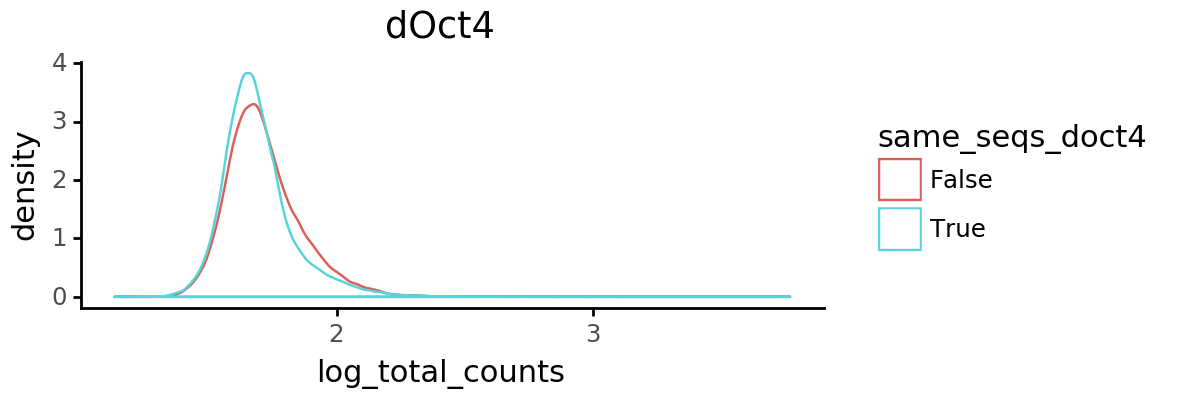

<ggplot: (8740064526898)>

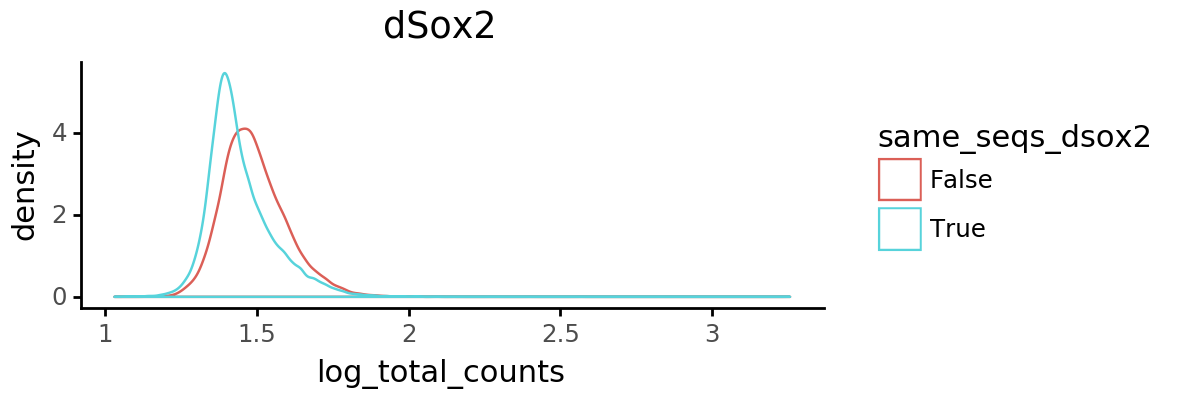

<ggplot: (-9223363292630222511)>

In [168]:
plotnine.options.figure_size = get_figsize(.7, 1/3)
g = (ggplot(aes(color='same_seqs_doct4', x='log_total_counts'), dfpm[((dfpm['task'] == 'Oct4') & (dfpm['seq'] == 'wt'))])
 + geom_density()
 + ggtitle("dOct4")
 # + geom_boxplot()
 # + facet_grid("task ~ .")
 + theme_classic()
)
display(g)

plotnine.options.figure_size = get_figsize(.7, 1/3)
g = (ggplot(aes(color='same_seqs_dsox2', x='log_total_counts'), dfpm[((dfpm['task'] == 'Sox2') & (dfpm['seq'] == 'wt'))])
 + geom_density()
 + ggtitle("dSox2")
 # + geom_boxplot()
 # + facet_grid("task ~ .")
 + theme_classic()
)
display(g);

In [132]:
# Large majority of sequences is the same

In [159]:
dfp

seq,idx,task,doct4,dsox2,random,wt
0,0,Klf4,1.2844,1.2844,1.2810,1.2844
1,0,Nanog,1.6858,1.6858,1.7849,1.6858
2,0,Oct4,1.4325,1.4325,1.3587,1.4325
...,...,...,...,...,...,...
591893,147973,Nanog,2.3922,2.2780,2.1176,2.3922
591894,147973,Oct4,1.8577,1.8130,1.7364,1.8577
591895,147973,Sox2,1.5996,1.5388,1.4440,1.5996


In [161]:
dfp['same_seqs_doct4'] = same_seqs_doct4[dfp.idx]
dfp['same_seqs_dsox2'] = same_seqs_dsox2[dfp.idx]

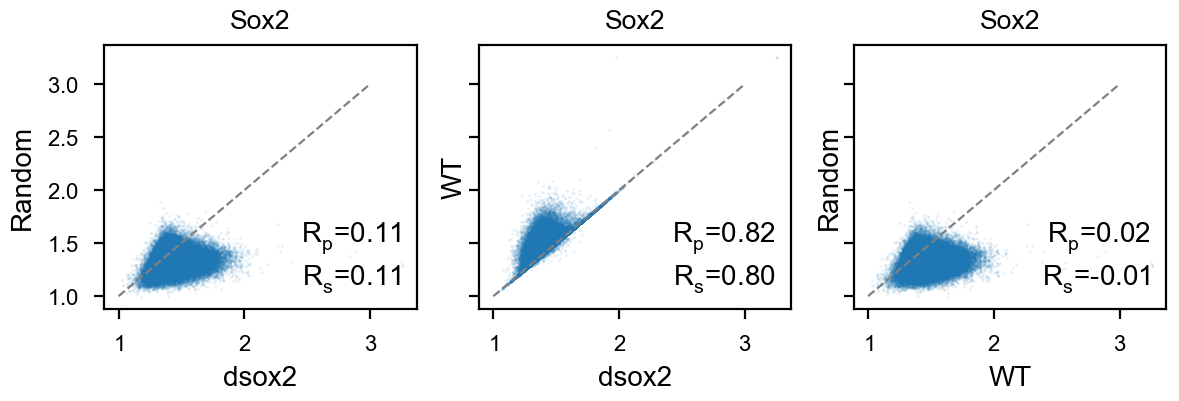

In [162]:
fig, axes = plt.subplots(1, 3, figsize=get_figsize(1, 1/4), 
                         gridspec_kw=dict(wspace=0.2),
                         sharex=True, sharey=True)

ax = axes[0]
regression_eval(dfp[dfp['task'] == 'Sox2']['random'], 
                dfp[dfp['task'] == 'Sox2']['dsox2'], task=f'Sox2', alpha=0.1, ax=ax);
ax.plot([1, 3], [1,3], '--', color='gray')
ax.set_ylabel("Random")
ax.set_xlabel("dsox2");

ax = axes[1]
regression_eval(dfp[dfp['task'] == 'Sox2']['wt'], 
                dfp[dfp['task'] == 'Sox2']['dsox2'], task=f'Sox2', alpha=0.1, ax=ax);
ax.plot([1, 3], [1,3], '--', color='gray')
ax.set_ylabel("WT")
ax.set_xlabel("dsox2");

ax = axes[2]
regression_eval(dfp[dfp['task'] == 'Sox2']['random'], 
                dfp[dfp['task'] == 'Sox2']['wt'], task=f'Sox2', alpha=0.1, ax=ax);
ax.plot([1, 3], [1,3], '--', color='gray')
ax.set_ylabel("Random")
ax.set_xlabel("WT");

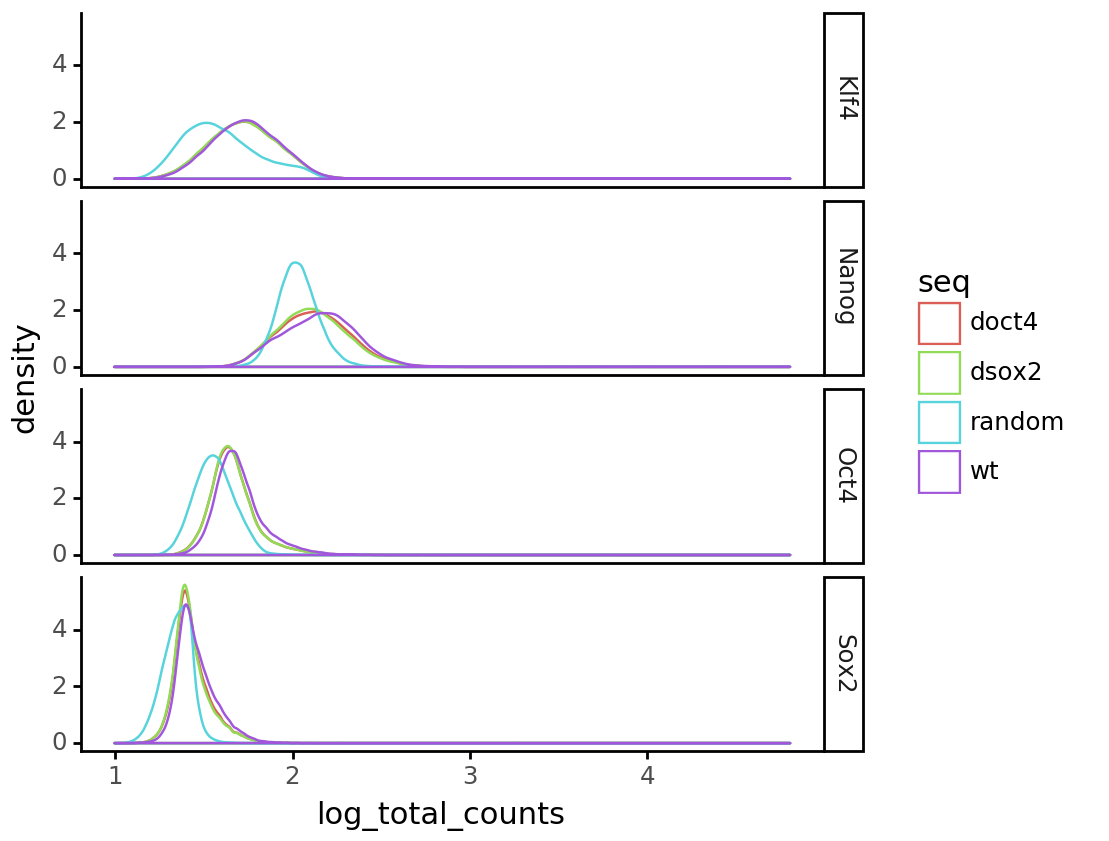

<ggplot: (8740078296794)>

In [101]:
plotnine.options.figure_size = get_figsize(.7, 1)
(ggplot(aes(x='log_total_counts', color='seq'), dfpm)
 # + geom_histogram(bins=100)
 + geom_density()
 + facet_grid("task ~ .")
 + theme_classic()
)

In [96]:
dfpm

,seq,idx,task,total_counts,log_total_counts
0,wt,0,Oct4,26.0682,1.4325
1,wt,1,Oct4,5831.3496,3.7658
2,wt,2,Oct4,108.6209,2.0399
...,...,...,...,...,...
2367581,random,147971,Klf4,117.3674,2.0732
2367582,random,147972,Klf4,70.8108,1.8562
2367583,random,147973,Klf4,36.8605,1.5782


In [71]:
pred_max_profile = {k: {task: (v / v.sum(axis=1, keepdims=True)).max(axis=1).mean(axis=-1) for task,v in d.items()}
                    for k,d in pred_dict.items()}

### Create features

#### Number of motifs per region

In [74]:
X_feat = dfi.groupby(['example_idx', 'pattern_name']).size().unstack(fill_value=0).reset_index()
X_feat = pd.merge(ranges[['example_idx']], X_feat, on='example_idx', how='left').fillna(0)
del X_feat['example_idx']

In [ ]:
def prefix_name(df, prefix):
    df = df.copy()
    df.columns = [prefix + c for c in df.columns]
    return df

In [ ]:
ranges = pd.concat([ranges, prefix_name(X_feat, 'motif_counts_')], axis=1)

## Add motif features

In [260]:
X_feat = dfi.groupby(['example_idx', 'pattern_name']).seq_match.max().unstack(fill_value=0).reset_index()
X_feat = pd.merge(ranges[['example_idx']], X_feat, on='example_idx', how='left').fillna(0)
del X_feat['example_idx']
ranges = pd.concat([ranges, prefix_name(X_feat, 'motif_seq_match_max_')], axis=1)

In [261]:
X_feat = dfi.groupby(['example_idx', 'pattern_name']).seq_match.mean().unstack(fill_value=0).reset_index()
X_feat = pd.merge(ranges[['example_idx']], X_feat, on='example_idx', how='left').fillna(0)
del X_feat['example_idx']
ranges = pd.concat([ranges, prefix_name(X_feat, 'motif_seq_match_mean_')], axis=1)

In [262]:
X_feat = dfi.groupby(['example_idx', 'pattern_name']).seq_match_p.max().unstack(fill_value=0).reset_index()
X_feat = pd.merge(ranges[['example_idx']], X_feat, on='example_idx', how='left').fillna(0)
del X_feat['example_idx']
ranges = pd.concat([ranges, prefix_name(X_feat, 'motif_seq_match_max_p_')], axis=1)

X_feat = dfi.groupby(['example_idx', 'pattern_name']).seq_match_p.mean().unstack(fill_value=0).reset_index()
X_feat = pd.merge(ranges[['example_idx']], X_feat, on='example_idx', how='left').fillna(0)
del X_feat['example_idx']
ranges = pd.concat([ranges, prefix_name(X_feat, 'motif_seq_match_mean_p_')], axis=1)

#### Number of motif pairs per region

In [77]:
from basepair.exp.chipnexus.spacing import remove_edge_instances, get_motif_pairs, motif_pair_dfi


In [78]:
# Generate motif pairs
pairs = get_motif_pairs(motifs)

# ordered names
pair_names = ["<>".join(x) for x in pairs]

In [79]:
# create motif pairs
dfab = pd.concat([motif_pair_dfi(dfi[(~dfi.is_te) & (~dfi.is_erv)], pair).assign(motif_pair="<>".join(pair)) for pair in pairs], axis=0)

In [80]:
# Remove self matches
dfab = dfab.query('~((pattern_center_aln_x == pattern_center_aln_y) & (pattern_strand_aln_x == pattern_strand_aln_x))')

#### Remove Sox2 and Oct4 matching exactly to Oct4-Sox2

In [81]:
exclude_sox2 = dfab[(dfab.motif_pair == 'Oct4-Sox2<>Sox2') & 
                    (dfab['center_diff_aln'] == 0)].row_idx_y.values
exclude_oct4 = dfab[(dfab.motif_pair == 'Oct4-Sox2<>Oct4') & 
                    (dfab['center_diff_aln'] == 0)].row_idx_y.values
exclude_oct4_v2 = dfab[(dfab.motif_pair == 'Oct4<>Oct4-Oct4') & 
                    (dfab['center_diff_aln'] == 0)].row_idx_y.values


old_len = len(dfab)
# Exclude the overlapping row
dfab = dfab[(dfab.pattern_name_x != 'Oct4') | (~dfab.row_idx_x.isin(exclude_oct4))]
dfab = dfab[(dfab.pattern_name_y != 'Oct4') | (~dfab.row_idx_y.isin(exclude_oct4))]
dfab = dfab[(dfab.pattern_name_x != 'Oct4') | (~dfab.row_idx_x.isin(exclude_oct4_v2))]
dfab = dfab[(dfab.pattern_name_y != 'Oct4') | (~dfab.row_idx_y.isin(exclude_oct4_v2))]
dfab = dfab[(dfab.pattern_name_x != 'Sox2') | (~dfab.row_idx_x.isin(exclude_sox2))]
dfab = dfab[(dfab.pattern_name_y != 'Sox2') | (~dfab.row_idx_y.isin(exclude_sox2))]
nd = len(dfab) - old_len
print(f"Removed {nd}/{len(dfab)} instances")

Removed 0/198565 instances


### Compare ChIP-nexus counts to ATAC-seq signal

In [82]:
nexus_counts = pd.DataFrame({k:v.sum(axis=(1,2)) for k,v in profiles.items()})

In [83]:
ranges = pd.concat([ranges, nexus_counts], axis=1)

In [84]:
tasks

['Oct4', 'Sox2', 'Nanog', 'Klf4']

In [85]:
from scipy.stats import pearsonr, spearmanr
df_cor_list = []
for sample in samples:
    for task in tasks:
        y_true = ranges[task]+1
        y_pred = ranges[sample]+1
        spearman, spearman_pval = spearmanr(np.log10(y_true), np.log(y_pred))
        df_cor_list.append(dict(sample=sample, task=task, spearman=spearman))
df_cor = pd.DataFrame(df_cor_list)

In [86]:
df_cor['tf_time'] = df_cor['sample'].map(lambda x: x[5:9] + '_' + x.split('_')[-1])
df_cor['TF_expressed'] = df_cor['sample'].map(lambda x: x.split('_')[1][4:])

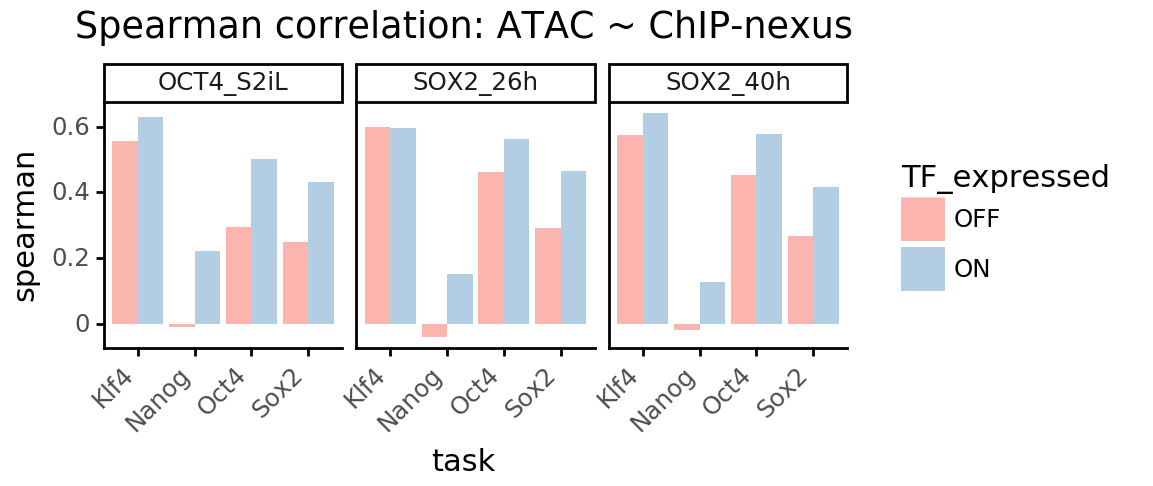

<ggplot: (-9223363283596150682)>

In [118]:
from basepair.plot.utils import plt9_tilt_xlab

plotnine.options.figure_size = get_figsize(.7, 1/3)
(ggplot(aes(x='task', y='spearman', fill='TF_expressed'), df_cor)
 + geom_bar(stat='identity', position='dodge')
 + facet_grid(".~tf_time")
 + scale_fill_brewer('qual', 4)
 + theme_classic()
 + plt9_tilt_xlab()
 + ggtitle("Spearman correlation: ATAC ~ ChIP-nexus")
)

#### Scatterplots: ATAC ~ ChIP-nexus

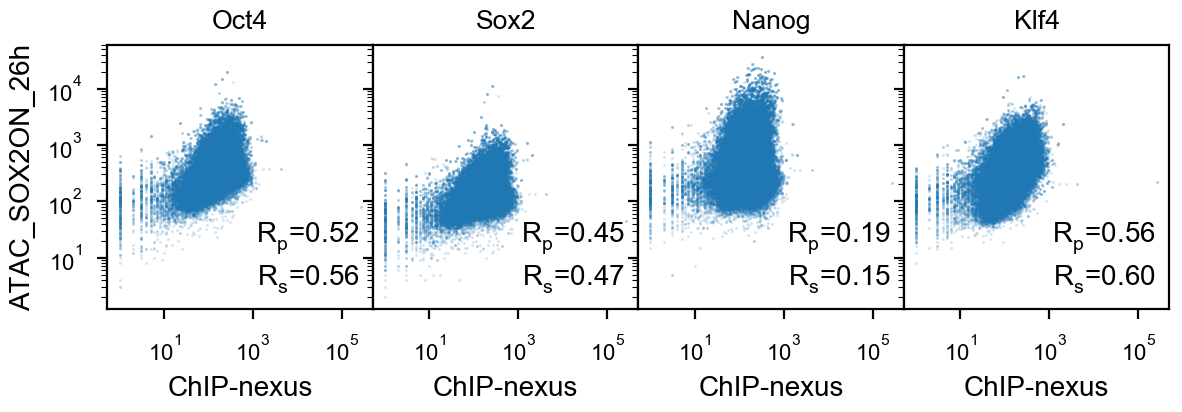

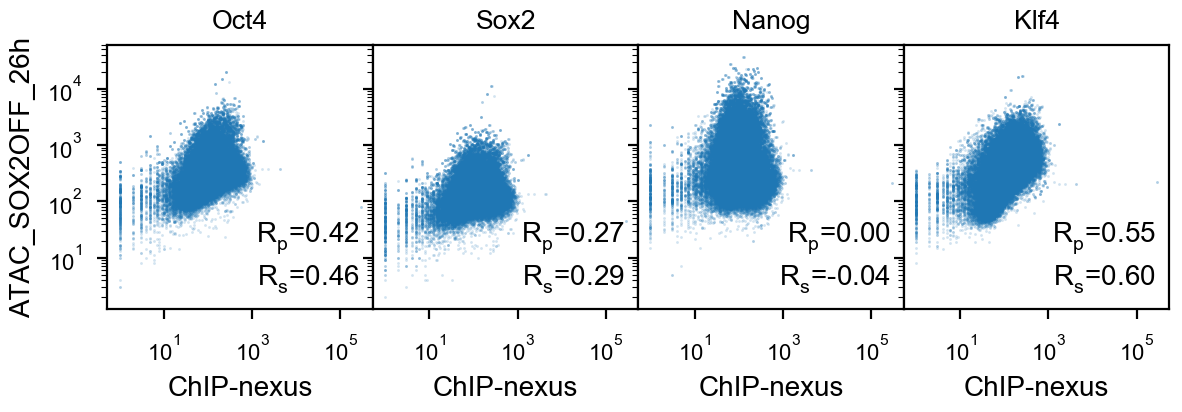

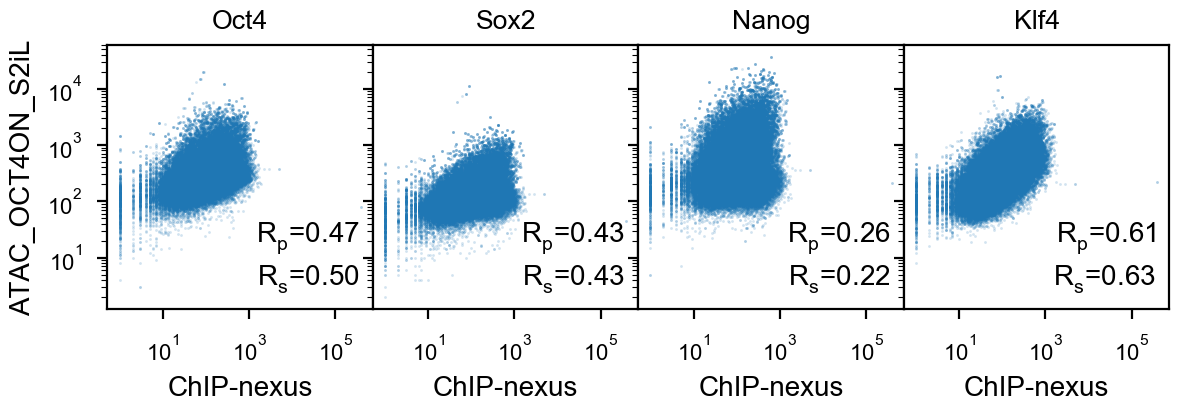

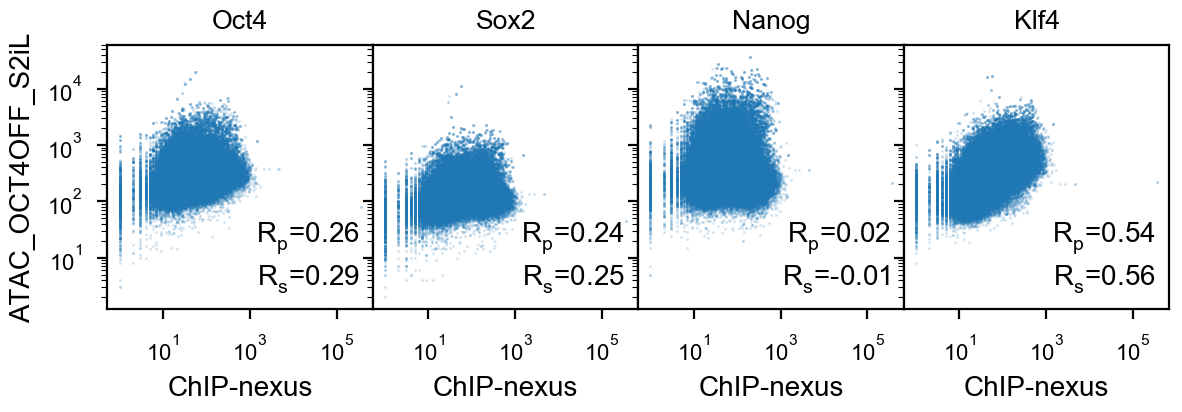

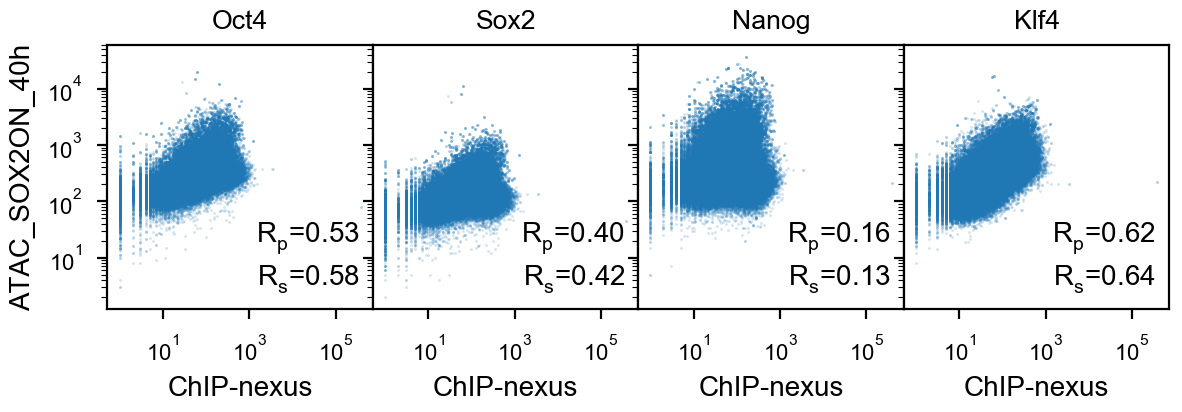

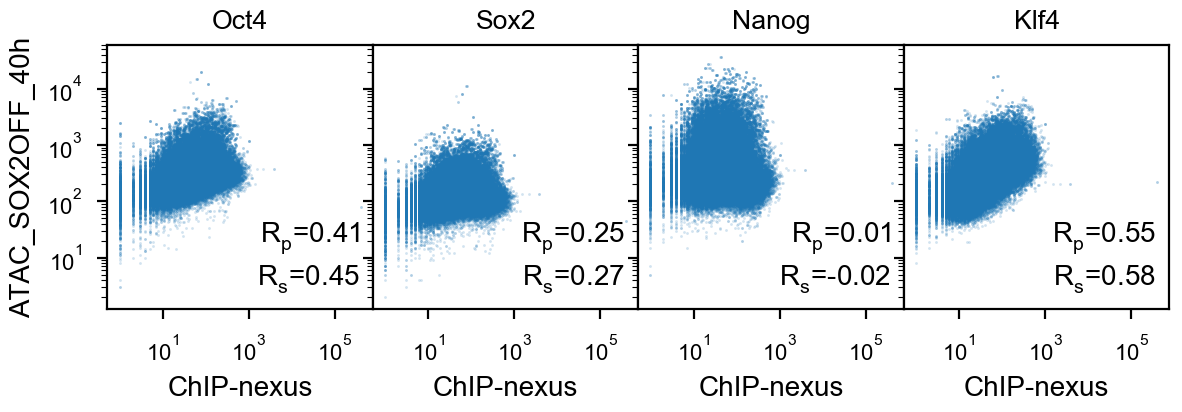

In [119]:
for sample in samples:
    fig, axes = plt.subplots(1, len(tasks),
                             figsize=get_figsize(1, aspect=1/len(tasks)),
                             gridspec_kw=dict(wspace=0),
                             sharex=True,
                             sharey=True)
    for i, (ax, task) in enumerate(zip(axes, tasks)):
        regression_eval(ranges[task]+1, ranges[sample]+1, loglog=True, task=task, alpha=0.2, ax=ax);
        if i == 0:
            ax.set_ylabel(sample)
        else:
            ax.set_ylabel(None)
        ax.set_xlabel("ChIP-nexus")

In [80]:
ranges

,chrom,start,end,strand,interval_from_task,idx,overlaps_ATAC_SOX2ON_26h,overlaps_ATAC_SOX2OFF_26h,overlaps_ATAC_OCT4ON_S2iL,overlaps_ATAC_OCT4OFF_S2iL,overlaps_ATAC_SOX2ON_40h,overlaps_ATAC_SOX2OFF_40h,ATAC_SOX2ON_26h,ATAC_SOX2OFF_26h,ATAC_OCT4ON_S2iL,ATAC_OCT4OFF_S2iL,ATAC_SOX2ON_40h,ATAC_SOX2OFF_40h,example_idx,motif_counts_B-Box,motif_counts_Essrb,motif_counts_Klf4,motif_counts_Klf4-Klf4,motif_counts_Nanog,motif_counts_Nanog-partner,motif_counts_Oct4,motif_counts_Oct4-Oct4,motif_counts_Oct4-Sox2,motif_counts_Sox2,motif_counts_Zic3,Klf4,Nanog,Oct4,Sox2
0,chr9,3001633,3002633,.,Oct4,0,False,True,False,False,False,False,198.0,204.0,74.0,42.0,56.0,61.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16088.0,22487.0,15004.0,8182.0
1,chr3,122145077,122146077,.,Oct4,1,False,True,True,False,True,True,142.0,147.0,267.0,32.0,198.0,111.0,1,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,4.0,0.0,0.0,488.0,17284.0,12070.0,3087.0
2,chr13,21199761,21200761,.,Oct4,2,True,True,True,True,True,True,212.0,284.0,280.0,189.0,205.0,186.0,2,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,460.0,198.0,4407.0,250.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147971,chr9,65390119,65391119,.,Klf4,147971,False,False,False,False,False,False,98.0,95.0,57.0,65.0,54.0,56.0,147971,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,201.0,140.0,176.0,100.0
147972,chr13,12440944,12441944,.,Klf4,147972,True,False,False,False,True,False,166.0,57.0,61.0,24.0,89.0,23.0,147972,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,227.0,3407.0,531.0,276.0
147973,chr13,101784985,101785985,.,Klf4,147973,False,True,True,False,True,True,128.0,165.0,131.0,29.0,100.0,99.0,147973,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,206.0,219.0,307.0,98.0


### Define fold-change

In [120]:
ranges

,chrom,start,end,strand,interval_from_task,idx,overlaps_ATAC_SOX2ON_26h,overlaps_ATAC_SOX2OFF_26h,overlaps_ATAC_OCT4ON_S2iL,overlaps_ATAC_OCT4OFF_S2iL,overlaps_ATAC_SOX2ON_40h,overlaps_ATAC_SOX2OFF_40h,ATAC_SOX2ON_26h,ATAC_SOX2OFF_26h,ATAC_OCT4ON_S2iL,ATAC_OCT4OFF_S2iL,ATAC_SOX2ON_40h,ATAC_SOX2OFF_40h,example_idx,motif_counts_B-Box,motif_counts_Essrb,motif_counts_Klf4,motif_counts_Klf4-Klf4,motif_counts_Nanog,motif_counts_Nanog-partner,motif_counts_Oct4,motif_counts_Oct4-Oct4,motif_counts_Oct4-Sox2,motif_counts_Sox2,motif_counts_Zic3,Klf4,Nanog,Oct4,Sox2
0,chr9,3001633,3002633,.,Oct4,0,False,True,False,False,False,False,198.0,204.0,74.0,42.0,56.0,61.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16088.0,22487.0,15004.0,8182.0
1,chr3,122145077,122146077,.,Oct4,1,False,True,True,False,True,True,142.0,147.0,267.0,32.0,198.0,111.0,1,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,4.0,0.0,0.0,488.0,17284.0,12070.0,3087.0
2,chr13,21199761,21200761,.,Oct4,2,True,True,True,True,True,True,212.0,284.0,280.0,189.0,205.0,186.0,2,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,460.0,198.0,4407.0,250.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147971,chr9,65390119,65391119,.,Klf4,147971,False,False,False,False,False,False,98.0,95.0,57.0,65.0,54.0,56.0,147971,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,201.0,140.0,176.0,100.0
147972,chr13,12440944,12441944,.,Klf4,147972,True,False,False,False,True,False,166.0,57.0,61.0,24.0,89.0,23.0,147972,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,227.0,3407.0,531.0,276.0
147973,chr13,101784985,101785985,.,Klf4,147973,False,True,True,False,True,True,128.0,165.0,131.0,29.0,100.0,99.0,147973,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,206.0,219.0,307.0,98.0


In [125]:
_ranges_melt

,variable,value,log10_counts
0,ATAC_SOX2ON_26h,198.0,2.2989
1,ATAC_SOX2ON_26h,142.0,2.1553
2,ATAC_SOX2ON_26h,212.0,2.3284
...,...,...,...
887841,ATAC_SOX2OFF_40h,56.0,1.7559
887842,ATAC_SOX2OFF_40h,23.0,1.3802
887843,ATAC_SOX2OFF_40h,99.0,2.0000


In [52]:
_ranges_melt = ranges.melt(value_vars=samples)
_ranges_melt['log10_counts'] = np.log10(1 + _ranges_melt['value'])
_ranges_melt['variable'] = pd.Categorical(_ranges_melt['variable'], samples, ordered=True)
_ranges_melt['variable'].cat.rename_categories(lambda x: x.replace('ATAC_', ''), inplace=True)

/users/avsec/bin/anaconda3/envs/chipnexus/lib/python3.6/site-packages/plotnine/layer.py:360: UserWarning: stat_bin : Removed 24 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)
/users/avsec/bin/anaconda3/envs/chipnexus/lib/python3.6/site-packages/plotnine/layer.py:449: UserWarning: geom_histogram : Removed 12 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


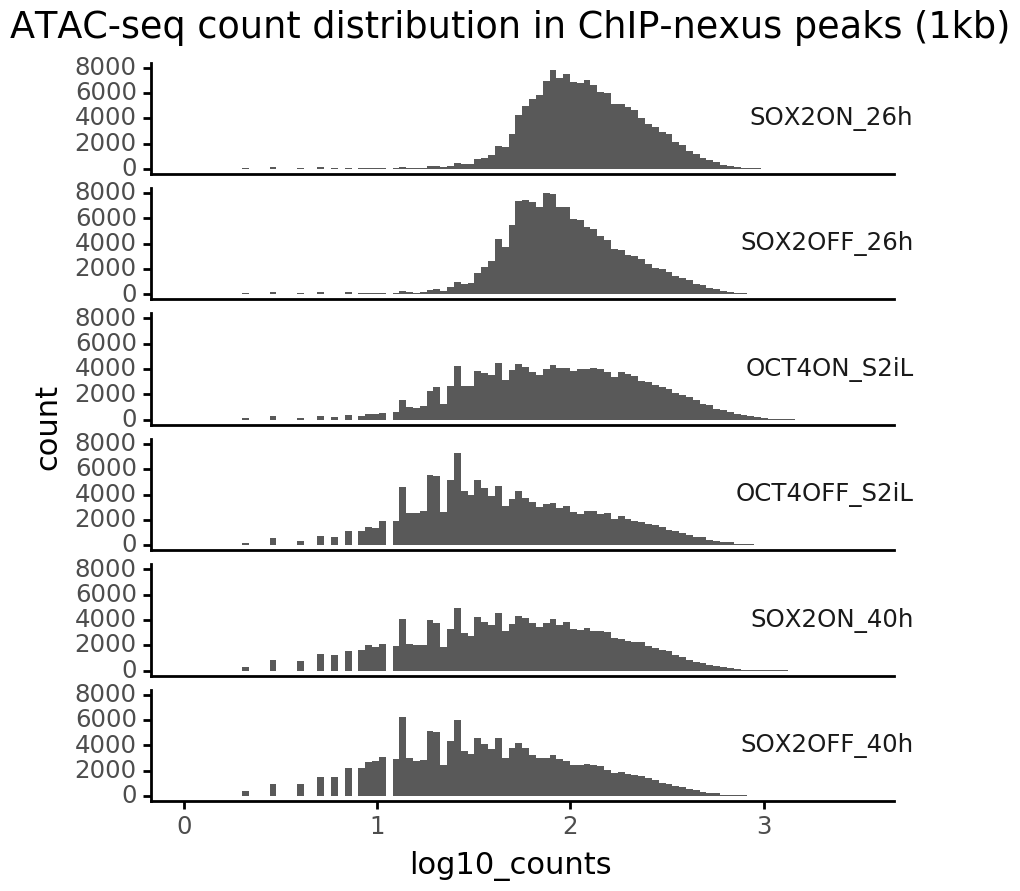

<ggplot: (-9223363283680757174)>

In [161]:
from basepair.plot.utils import plt9_horizontal_facet_label, plt9_remove_facet_label_box

plotnine.options.figure_size = get_figsize(.7, 1)
(ggplot(aes(x='log10_counts'), _ranges_melt)
 + geom_histogram(bins=100)
 + facet_grid('variable ~ .')
 + theme_classic()
 + plt9_horizontal_facet_label()
 + plt9_remove_facet_label_box()
 + xlim(0, 3.5)
 + ggtitle("ATAC-seq count distribution in ChIP-nexus peaks (1kb)")
)

In [87]:
on_samples = [s for s in samples if 'ON' in s]
feature_pairs = [(s, s.replace("ON", "OFF")) for s in samples if 'ON' in s]
sample_groups = [s.replace("ON", "").replace("ATAC_", "") for s in on_samples]

In [88]:
for on_sample in on_samples:
    counts_on = ranges[on_sample]
    counts_off = ranges[on_sample.replace("ON", "OFF")]
    counts_on_pc = np.percentile(counts_on, 10)
    counts_off_pc = np.percentile(counts_off, 10)
    fc = np.log10((counts_on + counts_on_pc) / (counts_off + counts_off_pc))
    ranges['log10_fc_' + on_sample.replace("ON", "").replace("ATAC_", "")] = fc

In [89]:
ranges[['log10_fc_' + s for s in sample_groups]].melt()

,variable,value
0,log10_fc_SOX2_26h,0.0105
1,log10_fc_SOX2_26h,0.0159
2,log10_fc_SOX2_26h,-0.0886
...,...,...
443919,log10_fc_SOX2_40h,0.0000
443920,log10_fc_SOX2_40h,0.4949
443921,log10_fc_SOX2_40h,0.0119


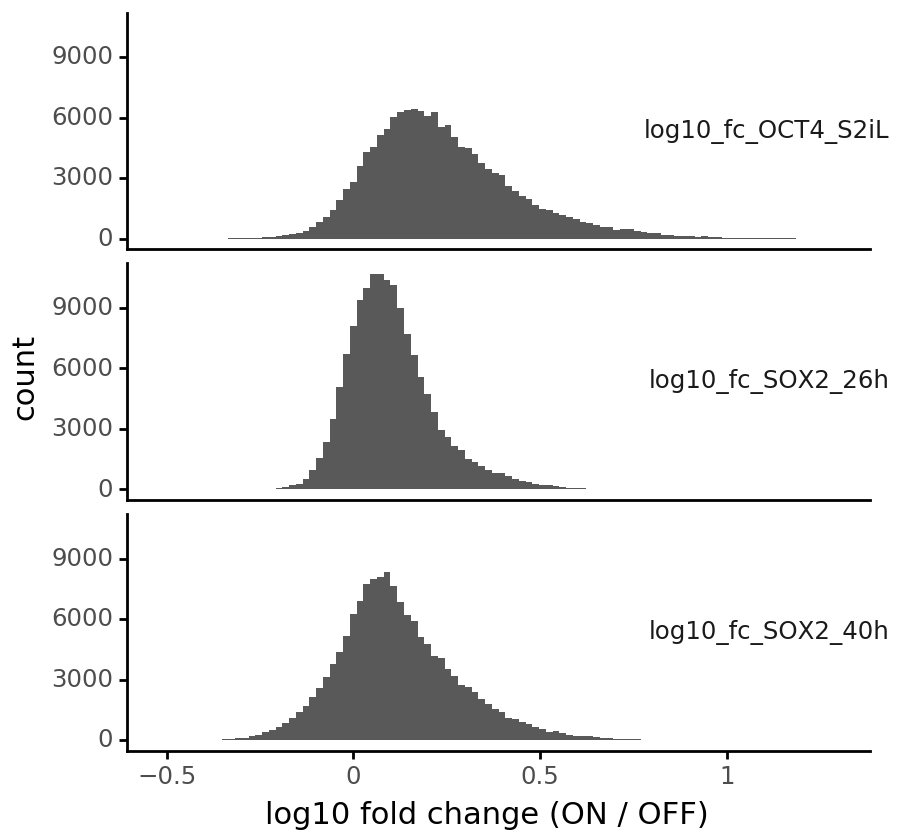

<ggplot: (-9223363283680991214)>

In [191]:
(ggplot(aes(x='value'), ranges[['log10_fc_' + s for s in sample_groups]].melt())
 + geom_histogram(bins=100)
 + theme_classic()
 + plt9_horizontal_facet_label()
 + plt9_remove_facet_label_box()
 + facet_grid("variable ~ .")
 + xlab("log10 fold change (ON / OFF)")
)

### Compare different models

fold_change ~ beta_TF1 * (alt_binding_TF1 - ref_binding_TF1) + ...

In [90]:
from scipy.stats import pearsonr, spearmanr
df_cor_list = []
for sample_group in sample_groups:
    for task in tasks:
        y_true = np.log10(ranges[task]+1)
        y_pred = ranges['log10_fc_' + sample_group]
        spearman, spearman_pval = spearmanr(y_true, y_pred)
        df_cor_list.append(dict(sample_group=sample_group, task=task, spearman=spearman))
df_cor = pd.DataFrame(df_cor_list)

/users/avsec/bin/anaconda3/envs/chipnexus/lib/python3.6/site-packages/plotnine/guides/guides.py:198: UserWarning: Cannot generate legend for the 'fill' aesthetic. Make sure you have mapped a variable to it
  "variable to it".format(output))


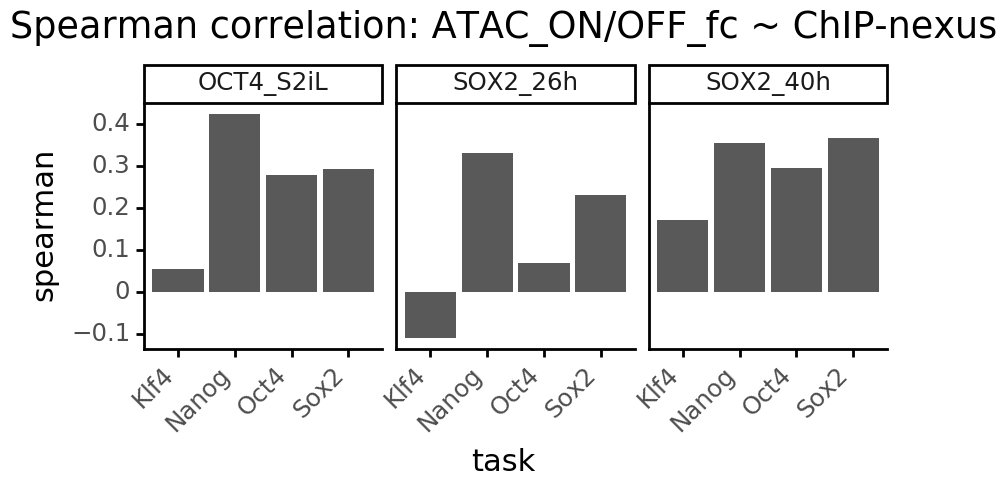

<ggplot: (-9223363283681098303)>

In [196]:
from basepair.plot.utils import plt9_tilt_xlab

plotnine.options.figure_size = get_figsize(.7, 1/3)
(ggplot(aes(x='task', y='spearman'), df_cor)
 + geom_bar(stat='identity', position='dodge')
 + facet_grid(".~sample_group")
 + scale_fill_brewer('qual', 4)
 + theme_classic()
 + plt9_tilt_xlab()
 + ggtitle("Spearman correlation: ATAC_ON/OFF_fc ~ ChIP-nexus")
)

### Create X

#### Summarize predictions

Counts in central 200 bp for each TF?

#### Motif counts (X_BPNet)

In [91]:
pred_dict.keys()

dict_keys(['wt', 'dsox2', 'doct4', 'random'])

In [92]:
pred_counts = {k: {task: v.sum(axis=(1,2)) for task,v in d.items()}
               for k,d in pred_dict.items()}

In [93]:
pred_max_profile = {k: {task: (v / v.sum(axis=1, keepdims=True)).max(axis=1).mean(axis=-1) for task,v in d.items()}
                    for k,d in pred_dict.items()}

In [94]:
X_bpnet_dsox2 = pd.DataFrame(pred_counts['wt']) - pd.DataFrame(pred_counts['dsox2'])
X_bpnet_doct4 = pd.DataFrame(pred_counts['wt']) - pd.DataFrame(pred_counts['doct4'])

#### Motif counts (X_motifs)

In [95]:
main_motifs

['Oct4-Sox2', 'Sox2', 'Nanog', 'Klf4']

In [96]:
motifs

['Oct4-Sox2',
 'Oct4',
 'Oct4-Oct4',
 'B-Box',
 'Sox2',
 'Nanog',
 'Nanog-partner',
 'Zic3',
 'Klf4',
 'Klf4-Klf4',
 'Essrb']

In [97]:
dsox2_motifs

['Oct4-Sox2', 'Sox2']

In [98]:
doct4_motifs

['Oct4-Sox2', 'Oct4', 'Oct4-Oct4']

In [99]:
X_motif_counts = ranges[['motif_counts_' + motif for motif in motifs]]
X_motif_counts.columns = [c.replace('motif_counts_', '') for c in X_motif_counts.columns]

In [ ]:
X_motif_counts_dsox2 = X_motif_counts[dsox2_motifs]  # wt - ref -> all the motifs cancel out except the key {dsox2_motifs}
X_motif_counts_doct4 = X_motif_counts[doct4_motifs]

In [264]:
features = ['motif_counts', 'motif_seq_match_mean', 'motif_seq_match_max', 'motif_seq_match_max_p', 'motif_seq_match_mean_p']

In [265]:
X_motif_counts_max_mean = ranges[[f'{f}_{motif}' for motif in motifs for f in features]]
X_motif_counts_max_mean_dsox2 = ranges[[f'{f}_{motif}' for motif in dsox2_motifs for f in features]]
X_motif_counts_max_mean_doct4 = ranges[[f'{f}_{motif}' for motif in doct4_motifs for f in features]]

#### Number of motifs per region

In [314]:
def prefix_name(df, prefix):
    df = df.copy()
    df.columns = [prefix + c for c in df.columns]
    return df

def aggregate_motifs(dfi, ref_example_idx, score, agg):
    X_feat = dfi.groupby(['example_idx', 'pattern_name'])[score].agg(agg).unstack(fill_value=0).reset_index()
    X_feat = pd.merge(ref_example_idx, X_feat, on='example_idx', how='left').fillna(0)
    del X_feat['example_idx']
    agg_name = 'motif_counts_' if agg == 'size' else f'motif_{score}_{agg}_'
    return prefix_name(X_feat, agg_name)

## Add motif features

In [276]:
# Max of motif instances
max_instances = dict(dfi.groupby('pattern_name').size())

In [281]:
dfi['max_n'] = dfi['pattern_name'].map(max_instances)

In [283]:
score = dfi_list['BPNet']['score']

In [290]:
# take only the top number of instances
dfi_topn = dfi.groupby('pattern_name').apply(lambda df: df.sort_values(score, ascending=False).iloc[:max_instances[df['pattern_name'].iloc[0]]])

In [307]:
dfi.pattern_name

0         Oct4/1
1         Oct4/1
2         Oct4/1
           ...  
136684    Klf4/1
136685    Klf4/1
136686    Klf4/1
Name: pattern_name, Length: 136644, dtype: object

In [341]:
from collections import defaultdict

In [354]:
X_methods_dict = {}
for method in dfi_list:
    print(method)
    v = dfi_list[method]
    dfi = v['dfi']
    score = v['score']
    motif_map = defaultdict(list)
    for motif in motifs:
        k = motif if v['motif_method'] == 'BPNet' else closest_motifs[motif][v['motif_method']][0].name
        motif_map[k].append(motif)
    motif_map = dict(motif_map)
    dfi = dfi[dfi.pattern_name.isin(list(motif_map))]
    
    new_max_instances = {k: max([max_instances[m] for m in motifs]) for k,motifs in motif_map.items()}
    dfi_topn = dfi.groupby('pattern_name', as_index=False).apply(lambda df: df.sort_values(score, ascending=False).iloc[:max_instances[df['pattern_name'].iloc[0]]])
    dfi_topn = dfi_topn.reset_index()
    # dfi_topn['pattern_name'] = dfi_topn.pattern_name.map({k: v[0] for k,v in motif_map.items()})
    X = pd.concat([
        aggregate_motifs(dfi_topn, ranges[['example_idx']], score=score, agg='size'),
        aggregate_motifs(dfi_topn, ranges[['example_idx']], score=score, agg='max'),
        aggregate_motifs(dfi_topn, ranges[['example_idx']], score=score, agg='mean'),
        aggregate_motifs(dfi_topn, ranges[['example_idx']], score=score, agg='sum'),
    ], axis=1)
    X_methods_dict[method] = X

ChExMix
Homer
MEME/FIMO
BPNet
BPNet-match
BPNet-seq-match
PWM-ChExMix
PWM-BPNet
BPNet-augm


In [355]:
X_methods_dict['ChExMix']

,motif_counts_Klf4/1,motif_counts_Nanog/1,motif_counts_Oct4/1,motif_counts_Sox2/1,motif_profile_score_max_Klf4/1,motif_profile_score_max_Nanog/1,motif_profile_score_max_Oct4/1,motif_profile_score_max_Sox2/1,motif_profile_score_mean_Klf4/1,motif_profile_score_mean_Nanog/1,motif_profile_score_mean_Oct4/1,motif_profile_score_mean_Sox2/1,motif_profile_score_sum_Klf4/1,motif_profile_score_sum_Nanog/1,motif_profile_score_sum_Oct4/1,motif_profile_score_sum_Sox2/1
0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.0,0.00,0.000
1,0.0,0.0,5.0,3.0,0.000,0.0,6.238,5.371,0.000,0.0,6.238,5.371,0.000,0.0,31.19,16.113
2,1.0,0.0,0.0,0.0,2.665,0.0,0.000,0.000,2.665,0.0,0.000,0.000,2.665,0.0,0.00,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147971,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.0,0.00,0.000
147972,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.0,0.00,0.000
147973,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.0,0.00,0.000


## -------------------------

In [225]:
ranges.head()

,chrom,start,end,strand,interval_from_task,idx,example_idx,overlaps_ATAC_SOX2ON_26h,overlaps_ATAC_SOX2OFF_26h,overlaps_ATAC_OCT4ON_S2iL,overlaps_ATAC_OCT4OFF_S2iL,overlaps_ATAC_SOX2ON_40h,overlaps_ATAC_SOX2OFF_40h,ATAC_SOX2ON_26h,ATAC_SOX2OFF_26h,ATAC_OCT4ON_S2iL,ATAC_OCT4OFF_S2iL,ATAC_SOX2ON_40h,ATAC_SOX2OFF_40h,motif_counts_B-Box,motif_counts_Essrb,motif_counts_Klf4,motif_counts_Klf4-Klf4,motif_counts_Nanog,motif_counts_Nanog-partner,motif_counts_Oct4,motif_counts_Oct4-Oct4,motif_counts_Oct4-Sox2,motif_counts_Sox2,motif_counts_Zic3,Klf4,Nanog,Oct4,Sox2,log10_fc_SOX2_26h,log10_fc_OCT4_S2iL,log10_fc_SOX2_40h
0,chr9,3001633,3002633,.,Oct4,0,0,False,True,False,False,False,False,198.0,204.0,74.0,42.0,56.0,61.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16088.0,22487.0,15004.0,8182.0,0.0105,0.2374,-0.0190
1,chr3,122145077,122146077,.,Oct4,1,1,False,True,True,False,True,True,142.0,147.0,267.0,32.0,198.0,111.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,4.0,0.0,0.0,488.0,17284.0,12070.0,3087.0,0.0159,0.8062,0.2410
2,chr13,21199761,21200761,.,Oct4,2,2,True,True,True,True,True,True,212.0,284.0,280.0,189.0,205.0,186.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,460.0,198.0,4407.0,250.0,-0.0886,0.1732,0.0444
3,chr8,20424345,20425345,.,Oct4,3,3,True,True,True,True,True,True,92.0,102.0,100.0,83.0,107.0,75.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,7134.0,916.0,2856.0,677.0,0.0060,0.1005,0.1476
4,chr6,47777726,47778726,.,Oct4,4,4,True,False,True,True,False,False,139.0,93.0,82.0,85.0,71.0,52.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1331.0,398.0,3500.0,337.0,0.1562,0.0216,0.1285


In [100]:
X_motif_counts

,Oct4-Sox2,Oct4,Oct4-Oct4,B-Box,Sox2,Nanog,Nanog-partner,Zic3,Klf4,Klf4-Klf4,Essrb
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
147971,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
147972,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
147973,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [101]:
X_motif_counts_dsox2 = X_motif_counts[dsox2_motifs]  # wt - ref -> all the motifs cancel out except the key {dsox2_motifs}
X_motif_counts_doct4 = X_motif_counts[doct4_motifs]

In [102]:
ranges

,chrom,start,end,strand,interval_from_task,idx,example_idx,overlaps_ATAC_SOX2ON_26h,overlaps_ATAC_SOX2OFF_26h,overlaps_ATAC_OCT4ON_S2iL,overlaps_ATAC_OCT4OFF_S2iL,overlaps_ATAC_SOX2ON_40h,overlaps_ATAC_SOX2OFF_40h,ATAC_SOX2ON_26h,ATAC_SOX2OFF_26h,ATAC_OCT4ON_S2iL,ATAC_OCT4OFF_S2iL,ATAC_SOX2ON_40h,ATAC_SOX2OFF_40h,motif_counts_B-Box,motif_counts_Essrb,motif_counts_Klf4,motif_counts_Klf4-Klf4,motif_counts_Nanog,motif_counts_Nanog-partner,motif_counts_Oct4,motif_counts_Oct4-Oct4,motif_counts_Oct4-Sox2,motif_counts_Sox2,motif_counts_Zic3,Klf4,Nanog,Oct4,Sox2,log10_fc_SOX2_26h,log10_fc_OCT4_S2iL,log10_fc_SOX2_40h
0,chr9,3001633,3002633,.,Oct4,0,0,False,True,False,False,False,False,198.0,204.0,74.0,42.0,56.0,61.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16088.0,22487.0,15004.0,8182.0,0.0105,0.2374,-0.0190
1,chr3,122145077,122146077,.,Oct4,1,1,False,True,True,False,True,True,142.0,147.0,267.0,32.0,198.0,111.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,4.0,0.0,0.0,488.0,17284.0,12070.0,3087.0,0.0159,0.8062,0.2410
2,chr13,21199761,21200761,.,Oct4,2,2,True,True,True,True,True,True,212.0,284.0,280.0,189.0,205.0,186.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,460.0,198.0,4407.0,250.0,-0.0886,0.1732,0.0444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147971,chr9,65390119,65391119,.,Klf4,147971,147971,False,False,False,False,False,False,98.0,95.0,57.0,65.0,54.0,56.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,201.0,140.0,176.0,100.0,0.0454,0.0000,0.0000
147972,chr13,12440944,12441944,.,Klf4,147972,147972,True,False,False,False,True,False,166.0,57.0,61.0,24.0,89.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,227.0,3407.0,531.0,276.0,0.3492,0.3456,0.4949
147973,chr13,101784985,101785985,.,Klf4,147973,147973,False,True,True,False,True,True,128.0,165.0,131.0,29.0,100.0,99.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,206.0,219.0,307.0,98.0,-0.0562,0.5586,0.0119


#### Fold change (Y)

In [103]:
Y = ranges[['log10_fc_' + g for g in sample_groups]]
Y

,log10_fc_SOX2_26h,log10_fc_OCT4_S2iL,log10_fc_SOX2_40h
0,0.0105,0.2374,-0.0190
1,0.0159,0.8062,0.2410
2,-0.0886,0.1732,0.0444
...,...,...,...
147971,0.0454,0.0000,0.0000
147972,0.3492,0.3456,0.4949
147973,-0.0562,0.5586,0.0119


In [104]:
# Fit linear model

In [365]:
from basepair.datasets import *
from basepair.config import valid_chr, test_chr
from kipoi.data_utils import numpy_collate
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict
from basepair.plot.evaluate import regression_eval

In [106]:
train = ~ranges.chrom.isin(valid_chr+test_chr)
valid = ranges.chrom.isin(valid_chr)
test = ranges.chrom.isin(test_chr)

In [107]:
X_motif_counts

,Oct4-Sox2,Oct4,Oct4-Oct4,B-Box,Sox2,Nanog,Nanog-partner,Zic3,Klf4,Klf4-Klf4,Essrb
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
147971,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
147972,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
147973,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [109]:
X_feat_pairs_short_range = (dfab[(dfab.center_diff > 10) & (dfab.center_diff <= 30)]
                            .groupby(['example_idx', 'motif_pair']).size().unstack(fill_value=0).reset_index())
X_feat_pairs_short_range = pd.merge(ranges[['example_idx']], X_feat_pairs_short_range, on='example_idx', how='left').fillna(0)
del X_feat_pairs_short_range['example_idx']

In [110]:
# 10% of motif instances have at least one motif_pair
(X_feat_pairs_short_range > 0).any(axis=1).mean()

0.0996323678484058

In [111]:
X_feat_pairs_proximal = (dfab[(dfab.center_diff > 10) & (dfab.center_diff <=150)]
                         .groupby(['example_idx', 'motif_pair']).size().unstack(fill_value=0).reset_index())
X_feat_pairs_proximal = pd.merge(ranges[['example_idx']], X_feat_pairs_proximal, on='example_idx', how='left').fillna(0)
del X_feat_pairs_proximal['example_idx']

In [114]:
oct4_involved_pairs = [c for c in X_feat_pairs_proximal.columns if 'Oct4' in c]
sox2_involved_pairs = [c for c in X_feat_pairs_proximal.columns if 'Sox2' in c]

## Only key motif pairs

In [172]:
import statsmodels.api as sm
from basepair.stats import tidy_ols


pval_threshold = 0.01

oct4_involved_pairs = [c for c in X_feat_pairs_proximal.columns if 'Oct4' in c]
sox2_involved_pairs = [c for c in X_feat_pairs_proximal.columns if 'Sox2' in c]

def standardize(x):
    return (x - x.mean()) / (x.std() + 0.01)

def binarize(x):
    return (x > 0).astype(float)

def transform(x):
    #return sm.add_constant(x)#(x > 0).astype(float)
    return sm.add_constant(standardize(binarize(x)))


X_sox2 = pd.concat([X_motif_counts[dsox2_motifs], X_feat_pairs_proximal[sox2_involved_pairs]], axis=1)
X_oct4 = pd.concat([X_motif_counts[doct4_motifs], X_feat_pairs_proximal[oct4_involved_pairs]], axis=1)

oct4_subset = ranges.overlaps_ATAC_OCT4ON_S2iL
sox2_subset = ranges.overlaps_ATAC_SOX2ON_26h

print("Nucleosome short range [10,150]")
print("Sox2")

# mutant - wt 
results = sm.OLS(-Y['log10_fc_SOX2_26h'][sox2_subset], transform(X_sox2[sox2_subset])).fit()
betas = tidy_ols(results).sort_values('coef')
print(betas[betas['P>|t|'].astype(float) < pval_threshold].to_string())

print("="*80)
print("Oct4")
results = sm.OLS(-Y['log10_fc_OCT4_S2iL'][oct4_subset], transform(X_oct4[oct4_subset])).fit()
betas = tidy_ols(results).sort_values('coef')
print(betas[betas['P>|t|'].astype(float) < pval_threshold].to_string())



X_sox2 = pd.concat([X_motif_counts[dsox2_motifs], X_feat_pairs_short_range[sox2_involved_pairs]], axis=1)
X_oct4 = pd.concat([X_motif_counts[doct4_motifs], X_feat_pairs_short_range[oct4_involved_pairs]], axis=1)


print("="*80)
print("="*80)

print("Only short range [10,30]")
print("Sox2")

# mutant - wt 
results = sm.OLS(-Y['log10_fc_SOX2_26h'][sox2_subset], transform(X_sox2[sox2_subset])).fit()
betas = tidy_ols(results).sort_values('coef')
print(betas[betas['P>|t|'].astype(float) < pval_threshold].to_string())

print("="*80)
print("Oct4")
results = sm.OLS(-Y['log10_fc_OCT4_S2iL'][oct4_subset], transform(X_oct4[oct4_subset])).fit()
betas = tidy_ols(results).sort_values('coef')
print(betas[betas['P>|t|'].astype(float) < pval_threshold].to_string())


Nucleosome short range [10,150]
Sox2
                        coef  std err        t  P>|t|  [0.025  0.975]
                                                                     
const                -0.1330    0.001 -159.511  0.000  -0.135  -0.131
Sox2                 -0.0213    0.001  -18.848  0.000  -0.024  -0.019
Oct4-Sox2            -0.0204    0.001  -18.710  0.000  -0.023  -0.018
Sox2<>Sox2           -0.0097    0.001   -9.889  0.000  -0.012  -0.008
Oct4-Sox2<>Oct4-Sox2 -0.0055    0.001   -4.840  0.000  -0.008  -0.003
Sox2<>Nanog          -0.0045    0.001   -4.393  0.000  -0.007  -0.002
Oct4<>Sox2           -0.0032    0.001   -2.857  0.004  -0.005  -0.001
Oct4-Sox2<>Nanog     -0.0029    0.001   -2.868  0.004  -0.005  -0.001
Oct4-Sox2<>Klf4       0.0030    0.001    3.060  0.002   0.001   0.005
B-Box<>Sox2           0.0039    0.001    3.427  0.001   0.002   0.006
Sox2<>Klf4            0.0047    0.001    4.695  0.000   0.003   0.007
Oct4
                        coef  std err        t  

## All motifs

In [173]:
import statsmodels.api as sm
from basepair.stats import tidy_ols

X_sox2 = pd.concat([X_motif_counts, X_feat_pairs_proximal], axis=1)
X_oct4 = pd.concat([X_motif_counts, X_feat_pairs_proximal], axis=1)

oct4_subset = ranges.overlaps_ATAC_OCT4ON_S2iL
sox2_subset = ranges.overlaps_ATAC_SOX2ON_26h

print("Nucleosome short range [10,150]")
print("Sox2")

# mutant - wt 
results = sm.OLS(-Y['log10_fc_SOX2_26h'][sox2_subset], transform(X_sox2[sox2_subset])).fit()
betas = tidy_ols(results).sort_values('coef')
print(betas[betas['P>|t|'].astype(float) < pval_threshold].to_string())

print("="*80)
print("Oct4")
results = sm.OLS(-Y['log10_fc_OCT4_S2iL'][oct4_subset], transform(X_oct4[oct4_subset])).fit()
betas = tidy_ols(results).sort_values('coef')
print(betas[betas['P>|t|'].astype(float) < pval_threshold].to_string())



X_sox2 = pd.concat([X_motif_counts, X_feat_pairs_short_range], axis=1)
X_oct4 = pd.concat([X_motif_counts, X_feat_pairs_short_range], axis=1)


print("="*80)
print("="*80)

print("Only short range [10,30]")
print("Sox2")

# mutant - wt 
results = sm.OLS(-Y['log10_fc_SOX2_26h'][sox2_subset], transform(X_sox2[sox2_subset])).fit()
betas = tidy_ols(results).sort_values('coef')
print(betas[betas['P>|t|'].astype(float) < pval_threshold].to_string())

print("="*80)
print("Oct4")
results = sm.OLS(-Y['log10_fc_OCT4_S2iL'][oct4_subset], transform(X_oct4[oct4_subset])).fit()
betas = tidy_ols(results).sort_values('coef')
print(betas[betas['P>|t|'].astype(float) < pval_threshold].to_string())


Nucleosome short range [10,150]
Sox2
                        coef  std err        t  P>|t|  [0.025  0.975]
                                                                     
const                -0.1330    0.001 -164.456  0.000  -0.135  -0.131
Sox2                 -0.0225    0.001  -20.164  0.000  -0.025  -0.020
Oct4-Sox2            -0.0210    0.001  -17.596  0.000  -0.023  -0.019
Sox2<>Sox2           -0.0088    0.001   -9.300  0.000  -0.011  -0.007
Oct4-Oct4            -0.0051    0.001   -4.487  0.000  -0.007  -0.003
Oct4-Sox2<>Oct4-Sox2 -0.0049    0.001   -4.483  0.000  -0.007  -0.003
Oct4<>Klf4           -0.0046    0.001   -4.043  0.000  -0.007  -0.002
Klf4<>Klf4-Klf4      -0.0046    0.001   -4.054  0.000  -0.007  -0.002
Sox2<>Nanog          -0.0039    0.001   -3.774  0.000  -0.006  -0.002
Sox2<>Klf4           -0.0030    0.001   -2.958  0.003  -0.005  -0.001
Klf4<>Klf4            0.0089    0.001    9.645  0.000   0.007   0.011
B-Box                 0.0100    0.001    9.480  0.000

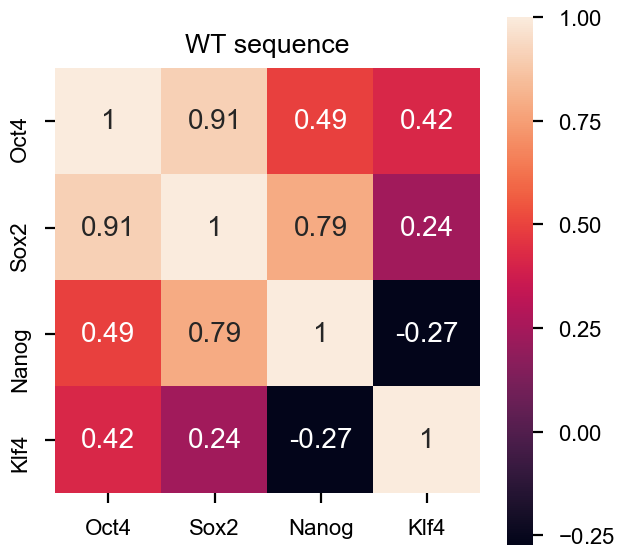

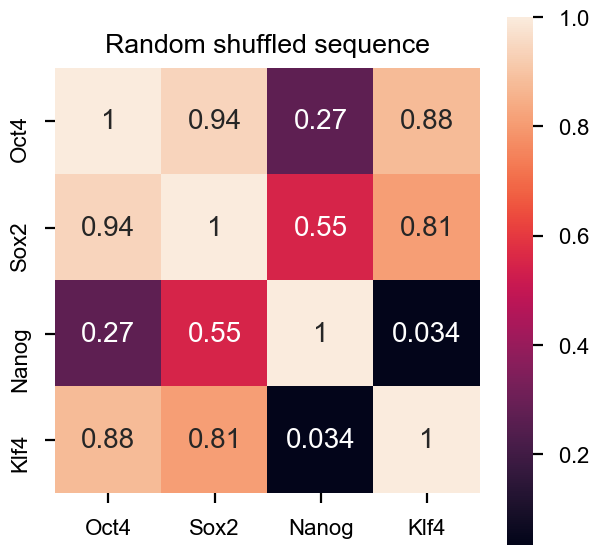

In [188]:
fig = plt.figure(figsize=get_figsize(.5, 1))
sns.heatmap(standardize(np.log(pd.DataFrame(pred_counts['wt']))).corr(), annot=True, square=True)
plt.title("WT sequence")

fig = plt.figure(figsize=get_figsize(.5, 1))
sns.heatmap(standardize(np.log(pd.DataFrame(pred_counts['random']))).corr(), annot=True, square=True)
plt.title("Random shuffled sequence");

In [174]:
# Model prediction analysis
import statsmodels.api as sm
from basepair.stats import tidy_ols

pval_threshold = 0.05

def transform(x):
    #return x #(x > 0).astype(float)
    return standardize(x)

oct4_subset = ranges.overlaps_ATAC_OCT4ON_S2iL
sox2_subset = ranges.overlaps_ATAC_SOX2ON_26h

print("="*80)
print("log(d<TF> / WT)")
X_sox2 = np.log(pd.DataFrame(pred_counts['dsox2']) / pd.DataFrame(pred_counts['wt'])) # / pd.DataFrame(pred_counts['random']))
X_oct4 = np.log(pd.DataFrame(pred_counts['doct4']) / pd.DataFrame(pred_counts['wt'])) # / pd.DataFrame(pred_counts['random']))


print("Sox2")

# mutant - wt 
results = sm.OLS(-Y['log10_fc_SOX2_26h'][sox2_subset], sm.add_constant(transform(X_sox2[sox2_subset]))).fit()
betas = tidy_ols(results).sort_values('coef')
print(betas[betas['P>|t|'].astype(float) < pval_threshold].to_string())

print("="*80)
print("Oct4")
results = sm.OLS(-Y['log10_fc_OCT4_S2iL'][oct4_subset], sm.add_constant(transform(X_oct4[oct4_subset]))).fit()
betas = tidy_ols(results).sort_values('coef')
print(betas[betas['P>|t|'].astype(float) < pval_threshold].to_string())


print("="*80)
print("="*80)
print("WT")

X_sox2 = np.log(pd.DataFrame(pred_counts['wt'])) # / pd.DataFrame(pred_counts['random']))
X_oct4 = np.log(pd.DataFrame(pred_counts['wt'])) # / pd.DataFrame(pred_counts['random']))


print("Sox2")

# mutant - wt 
results = sm.OLS(-Y['log10_fc_SOX2_26h'][sox2_subset], sm.add_constant(transform(X_sox2[sox2_subset]))).fit()
betas = tidy_ols(results).sort_values('coef')
print(betas[betas['P>|t|'].astype(float) < pval_threshold].to_string())

print("="*80)
print("Oct4")
results = sm.OLS(-Y['log10_fc_OCT4_S2iL'][oct4_subset], sm.add_constant(transform(X_oct4[oct4_subset]))).fit()
betas = tidy_ols(results).sort_values('coef')
betas
print(betas[betas['P>|t|'].astype(float) < pval_threshold].to_string())


log(d<TF> / WT)
Sox2
         coef  std err        t  P>|t|  [0.025  0.975]
                                                      
Oct4  -0.1758    0.017  -10.330    0.0  -0.209  -0.142
const -0.1330    0.001 -159.274    0.0  -0.135  -0.131
Nanog -0.0654    0.011   -5.921    0.0  -0.087  -0.044
Klf4  -0.0476    0.003  -16.550    0.0  -0.053  -0.042
Sox2   0.3161    0.029   11.062    0.0   0.260   0.372
Oct4
         coef  std err        t  P>|t|  [0.025  0.975]
                                                      
const -0.2758    0.001 -281.793    0.0  -0.278  -0.274
Oct4  -0.1667    0.017   -9.770    0.0  -0.200  -0.133
Nanog -0.0983    0.010   -9.439    0.0  -0.119  -0.078
Klf4  -0.0603    0.004  -15.588    0.0  -0.068  -0.053
Sox2   0.3833    0.028   13.694    0.0   0.328   0.438
WT
Sox2
         coef  std err        t  P>|t|  [0.025  0.975]
                                                      
const -0.1330    0.001 -208.184    0.0  -0.134  -0.132
Nanog -0.1137    0.004  -27.821

In [201]:
#bottleneck = m.seqmodel.bottleneck_model().predict(seqs)
bottleneck_dsox2 = m.seqmodel.bottleneck_model().predict(seq_dict['dsox2'])
bottleneck_doct4 = m.seqmodel.bottleneck_model().predict(seq_dict['doct4'])

In [202]:
bottleneck_features_dsox2 = pd.DataFrame(bottleneck_dsox2.mean(axis=1))
bottleneck_features_doct4 = pd.DataFrame(bottleneck_doct4.mean(axis=1))

In [196]:
bottleneck_features = pd.DataFrame(bottleneck.mean(axis=1))

In [358]:
X_motif_counts

,Oct4-Sox2,Oct4,Oct4-Oct4,B-Box,Sox2,Nanog,Nanog-partner,Zic3,Klf4,Klf4-Klf4,Essrb
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
147971,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
147972,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
147973,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [361]:
X_methods_dict.keys()

dict_keys(['ChExMix', 'Homer', 'MEME/FIMO', 'BPNet', 'BPNet-match', 'BPNet-seq-match', 'PWM-ChExMix', 'PWM-BPNet', 'BPNet-augm'])

In [368]:
datasets = {"dSox2": {"y": Y['log10_fc_SOX2_26h'],
                      "subset": ranges.overlaps_ATAC_SOX2ON_26h,
                      "x_list": {
                          'BPNet_bottleneck': bottleneck_features,
                          'BPNet_bottleneck_dsox2': bottleneck_features - bottleneck_features_dsox2,
                          'BPNet_diff': pd.DataFrame(pred_counts['wt']) - pd.DataFrame(pred_counts['dsox2']),
                          'BPNet_log_fc': np.log(pd.DataFrame(pred_counts['wt']) / pd.DataFrame(pred_counts['dsox2'])),
                          'BPNet_log_fc_random': np.log(pd.DataFrame(pred_counts['wt']) / pd.DataFrame(pred_counts['random'])),
                          'BPNet_maxref_fc': np.log(pd.DataFrame(pred_max_profile['wt']) / pd.DataFrame(pred_max_profile['dsox2'])),
                          'BPNet_maxref_diff': pd.DataFrame(pred_max_profile['wt']) - pd.DataFrame(pred_max_profile['dsox2']),
                          'BPNet_log_diff': np.log(pd.DataFrame(pred_counts['wt'])) - np.log(pd.DataFrame(pred_counts['dsox2'])),
                          'motif_counts': X_motif_counts[dsox2_motifs],
                          'motif_counts+pairs': pd.concat([X_motif_counts[dsox2_motifs], X_feat_pairs_proximal[sox2_involved_pairs]], axis=1),
                          'motif_counts+pairs-binary': binarize(pd.concat([X_motif_counts[dsox2_motifs], X_feat_pairs_proximal[sox2_involved_pairs]], axis=1)),
                          'motif_counts+all_pairs': pd.concat([X_motif_counts[dsox2_motifs], X_feat_pairs_proximal], axis=1),
                          'BPNet_wt_log': np.log(pd.DataFrame(pred_counts['wt'])),
                          'wt_motif_counts': X_motif_counts,
                          'wt_motifs_BPNet': X_methods_dict['BPNet'],
                          'wt_motifs_BPNet-seq-match': X_methods_dict['BPNet-seq-match'],
                          'wt_motifs_MEME/FIMO': X_methods_dict['MEME/FIMO'],
                          'wt_motifs_ChExMix': X_methods_dict['ChExMix'],
                          'wt_motif_counts_max_mean': X_motif_counts_max_mean,
                          'wt_motif_counts+pairs': pd.concat([X_motif_counts, X_feat_pairs_proximal], axis=1),
                      }},
            "dSox2_40h": {"y": Y['log10_fc_SOX2_40h'],
                          "subset": ranges.overlaps_ATAC_SOX2ON_26h,
                          "x_list": {
                             'BPNet_bottleneck': bottleneck_features,
                              'BPNet_bottleneck_dsox2': bottleneck_features - bottleneck_features_dsox2,
                              'BPNet_diff': pd.DataFrame(pred_counts['wt']) - pd.DataFrame(pred_counts['dsox2']),
                             'BPNet_log_fc': np.log(pd.DataFrame(pred_counts['wt']) / pd.DataFrame(pred_counts['dsox2'])),
                             'BPNet_log_fc_random': np.log(pd.DataFrame(pred_counts['wt']) / pd.DataFrame(pred_counts['random'])),
                             'BPNet_maxref_fc': np.log(pd.DataFrame(pred_max_profile['wt']) / pd.DataFrame(pred_max_profile['dsox2'])),
                             'BPNet_maxref_diff': pd.DataFrame(pred_max_profile['wt']) - pd.DataFrame(pred_max_profile['dsox2']),
                             'BPNet_log_diff': np.log(pd.DataFrame(pred_counts['wt'])) - np.log(pd.DataFrame(pred_counts['dsox2'])),
                             'motif_counts': X_motif_counts[dsox2_motifs],
                             'motif_counts+pairs': pd.concat([X_motif_counts[dsox2_motifs], X_feat_pairs_proximal[sox2_involved_pairs]], axis=1),
                            'motif_counts+pairs-binary': binarize(pd.concat([X_motif_counts[dsox2_motifs], X_feat_pairs_proximal[sox2_involved_pairs]], axis=1)),
                             'motif_counts+all_pairs': pd.concat([X_motif_counts[dsox2_motifs], X_feat_pairs_proximal], axis=1),
                             'BPNet_wt_log': np.log(pd.DataFrame(pred_counts['wt'])),
                             'wt_motifs_BPNet': X_methods_dict['BPNet'],
                              'wt_motifs_BPNet-seq-match': X_methods_dict['BPNet-seq-match'],
                            'wt_motifs_MEME/FIMO': X_methods_dict['MEME/FIMO'],
                              'wt_motifs_ChExMix': X_methods_dict['ChExMix'],
                              'wt_motif_counts': X_motif_counts,
                             'wt_motif_counts_max_mean': X_motif_counts_max_mean,
                             'wt_motif_counts+pairs': pd.concat([X_motif_counts, X_feat_pairs_proximal], axis=1),
                      }},
            "dOct4": {"y": Y['log10_fc_OCT4_S2iL'],
                      "subset": ranges.overlaps_ATAC_OCT4ON_S2iL,
                      "x_list": {
                          'BPNet_bottleneck': bottleneck_features,
                          'BPNet_bottleneck_doct4': bottleneck_features - bottleneck_features_doct4,
                          'BPNet_diff': pd.DataFrame(pred_counts['wt']) - pd.DataFrame(pred_counts['doct4']),
                          'BPNet_log_fc': np.log(pd.DataFrame(pred_counts['wt']) / pd.DataFrame(pred_counts['doct4'])),
                          'BPNet_log_fc_random': np.log(pd.DataFrame(pred_counts['wt']) / pd.DataFrame(pred_counts['random'])),
                          'BPNet_log_diff': np.log(pd.DataFrame(pred_counts['wt'])) - np.log(pd.DataFrame(pred_counts['doct4'])),
                          'BPNet_maxref_diff': pd.DataFrame(pred_max_profile['wt']) - pd.DataFrame(pred_max_profile['doct4']),
                          'BPNet_maxref_fc': np.log(pd.DataFrame(pred_max_profile['wt']) / pd.DataFrame(pred_max_profile['doct4'])),
                          'motif_counts': X_motif_counts[doct4_motifs],
                          'motif_counts+pairs': pd.concat([X_motif_counts[doct4_motifs], X_feat_pairs_proximal[oct4_involved_pairs]], axis=1),
                          'motif_counts+pairs-binary': binarize(pd.concat([X_motif_counts[doct4_motifs], X_feat_pairs_proximal[oct4_involved_pairs]], axis=1)),
                          'motif_counts+all_pairs': pd.concat([X_motif_counts[doct4_motifs], X_feat_pairs_proximal], axis=1),
                          'BPNet_wt_log': np.log(pd.DataFrame(pred_counts['wt'])),
                          'wt_motifs_BPNet': X_methods_dict['BPNet'],
                          'wt_motifs_BPNet-seq-match': X_methods_dict['BPNet-seq-match'],
                          'wt_motifs_MEME/FIMO': X_methods_dict['MEME/FIMO'],
                          'wt_motifs_ChExMix': X_methods_dict['ChExMix'],
                          'wt_motif_counts': X_motif_counts,
                          'wt_motif_counts_max_mean': X_motif_counts_max_mean,
                          'wt_motif_counts+pairs': pd.concat([X_motif_counts, X_feat_pairs_proximal], axis=1),
                      }},
           }

dSox2
dSox2_40h
dOct4


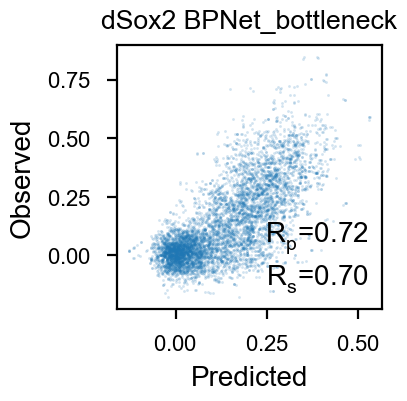

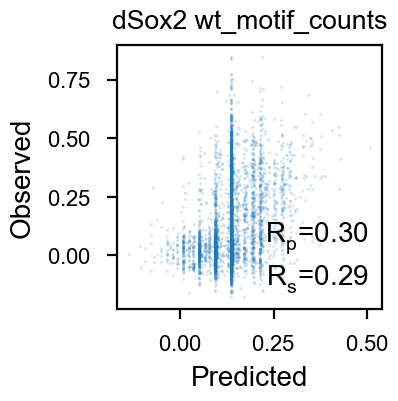

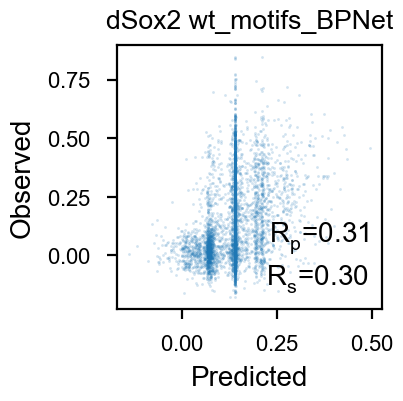

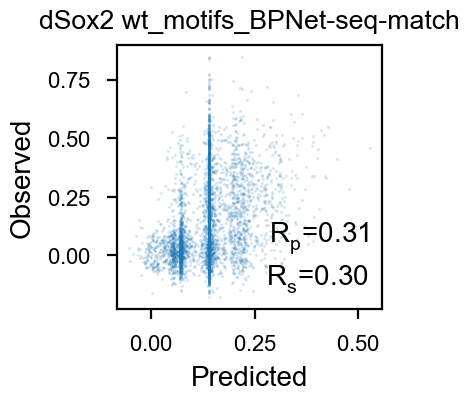

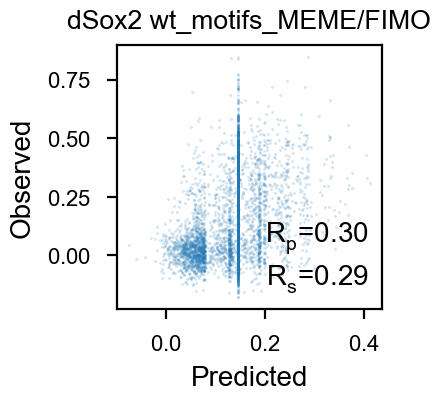

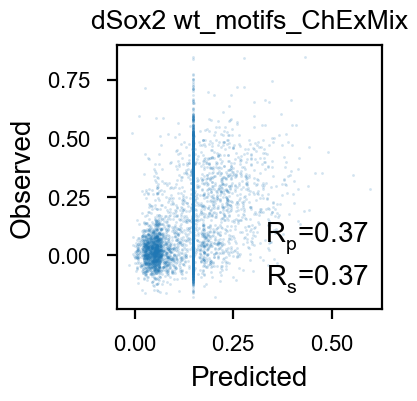

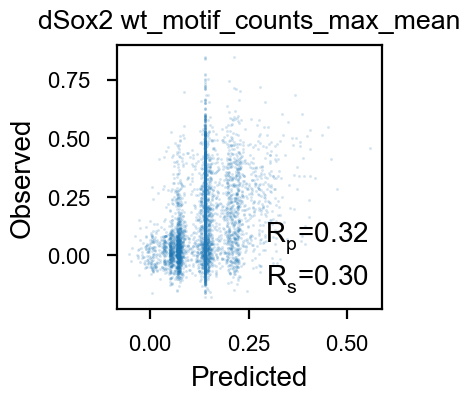

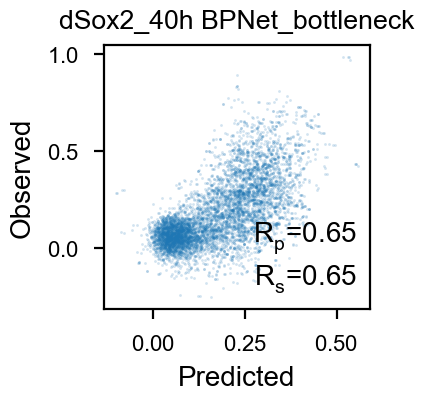

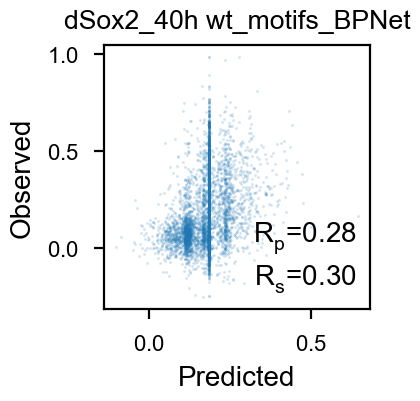

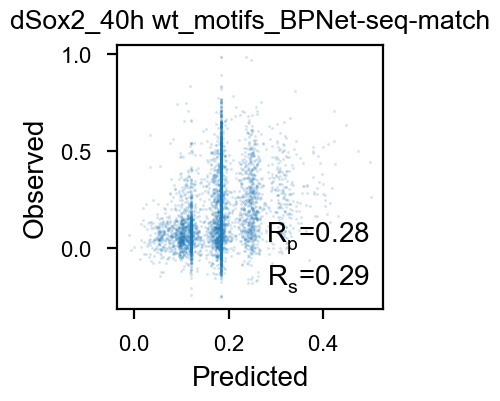

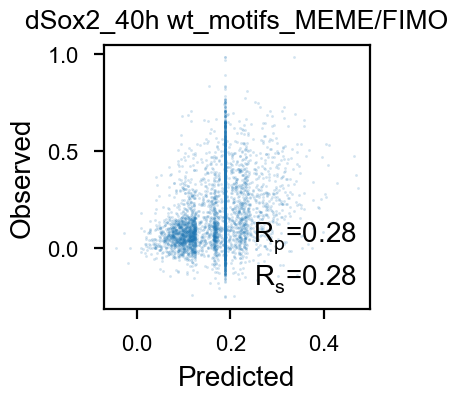

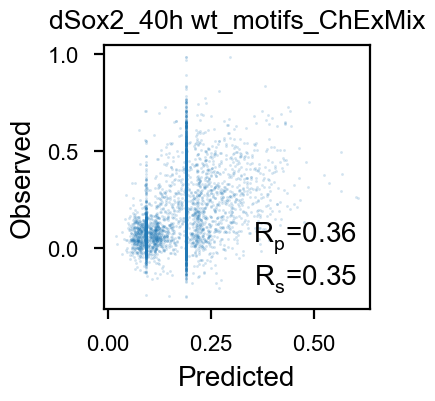

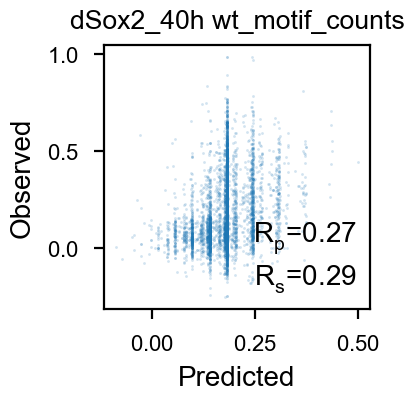

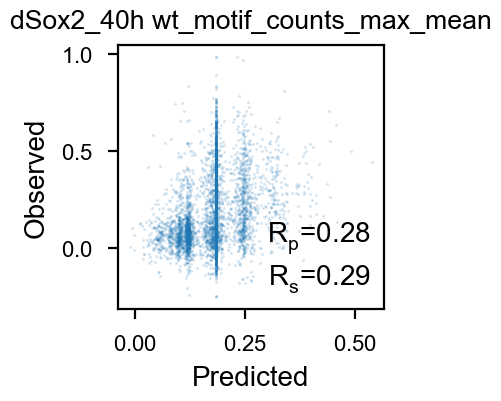

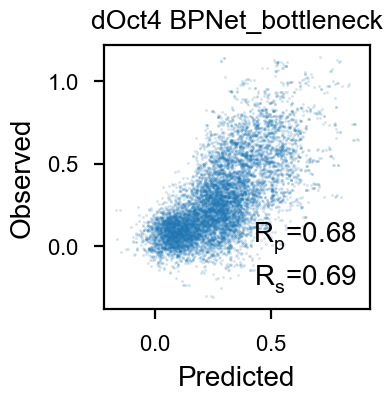

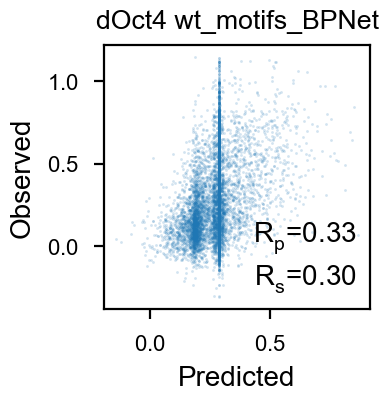

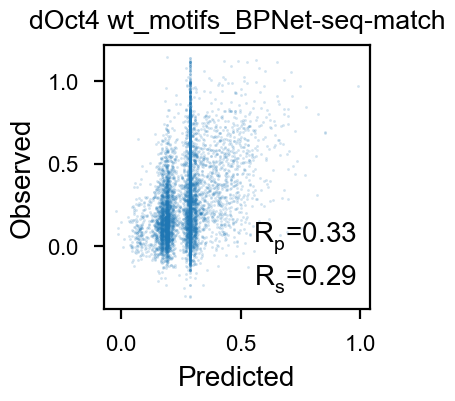

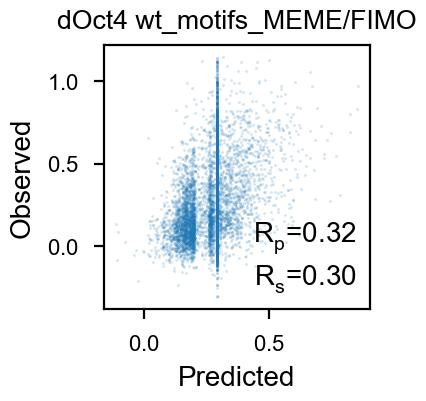

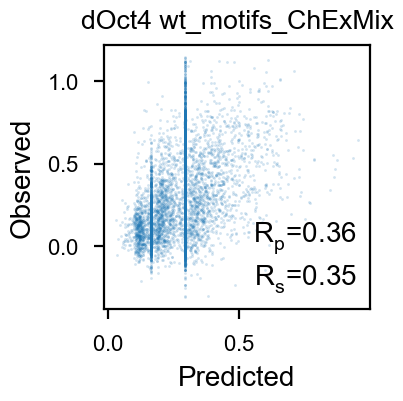

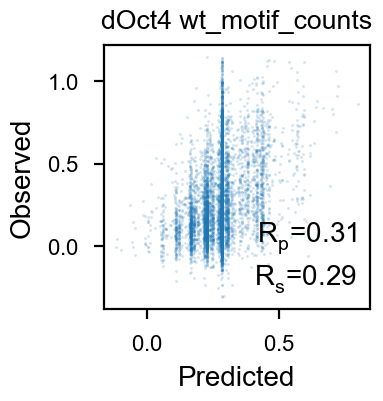

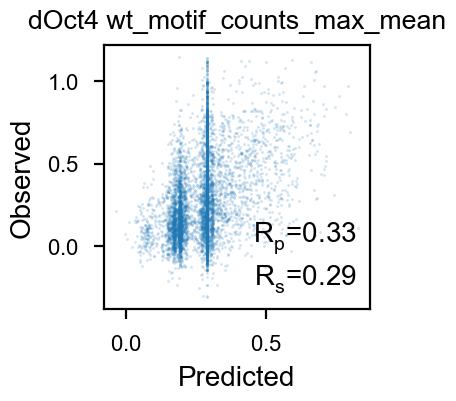

In [369]:
for dataset,v in datasets.items():
    print(dataset)
    y = v['y']
    for method, X in v['x_list'].items():
        if method not in ['BPNet_bottleneck',
                          'wt_motif_counts',
                          'wt_motif_counts_max_mean',
                          'wt_motifs_BPNet',
                          'wt_motifs_MEME/FIMO',
                          'wt_motifs_ChExMix',
                          'wt_motifs_BPNet-seq-match',
                         ]:
            continue
        model = LinearRegression()
        # m = RandomForestRegressor(n_estimators=100, n_jobs=5)
        model.fit(X[train & v['subset']].values, y[train & v['subset']].values)
        fig, ax = plt.subplots(figsize=get_figsize(0.25, 1))
        regression_eval(y[test & v['subset']], model.predict(X[test & v['subset']]), task=f'{dataset} {method}',
                        alpha=0.2, ax=ax);
        m = method.replace('/', '-')
        fig.savefig(fdir_atac / f'scatter.{dataset}.{m}.pdf', dpi=600)

In [ ]:
for dataset,v in datasets.items():
    print(dataset)
    y = v['y']
    for method, X in v['x_list'].items():
        model = LinearRegression()
        # m = RandomForestRegressor(n_estimators=100, n_jobs=5)
        model.fit(X[train & v['subset']].values, y[train & v['subset']].values)
        fig, ax = plt.subplots(figsize=(3, 3))
        regression_eval(y[test & v['subset']], model.predict(X[test & v['subset']]), task=f'{dataset} {method}', alpha=0.5, ax=ax);

In [ ]:
for dataset,v in datasets.items():
    print(dataset)
    y = v['y']
    for method, X in v['x_list'].items():
        # model = LinearRegression()
        model = RandomForestRegressor(n_estimators=100, n_jobs=5)
        model.fit(X[train].values, y[train].values)
        fig, ax = plt.subplots(figsize=(3, 3))
        regression_eval(y[test], model.predict(X[test]), task=f'{dataset} {method}', alpha=0.5, ax=ax);